# PreProcessing

## Import Modules and Dataset

In [262]:
import sqlite3
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
from decimal import Decimal
from math import ceil
from datetime import datetime
from sklearn.impute import KNNImputer
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.cluster import DBSCAN, KMeans, AgglomerativeClustering
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder
from sklearn.neighbors import NearestNeighbors, KNeighborsClassifier
from sklearn.base import clone
from sklearn.model_selection import train_test_split
from collections import defaultdict
from scipy.stats import hmean
from scipy.spatial.distance import cdist
from sklearn.metrics import pairwise_distances
from scipy.cluster.hierarchy import dendrogram
from sklearn.manifold import TSNE
import umap



from scipy import stats
import numbers

from sklearn.neighbors import LocalOutlierFactor
from kmodes.kprototypes import KPrototypes
from kmodes.kmodes import KModes
from pandas_profiling import ProfileReport
import pyreadstat

%matplotlib inline
# for better resolution plots
%config InlineBackend.figure_format = 'retina' # optionally, you can change 'svg' to 'retina'

# Seeting seaborn style
sns.set()

In [2]:
df,meta = pyreadstat.read_sas7bdat('a2z_insurance.sas7bdat')
# dataset head
df.set_index('CustID',inplace=True)

In [3]:
# initalise empty pandas dataframe
df_metadata = pd.DataFrame()

# read column name, labels into the new pandas dataframe
df_metadata["name"] = meta.column_names
df_metadata["label"] = meta.column_labels

df_metadata.T

0             1          2        3         4           5   \
name   CustID  FirstPolYear  BirthYear  EducDeg  MonthSal  GeoLivArea   
label    None          None       None     None      None        None   

             6           7           8          9              10          11  \
name   Children  CustMonVal  ClaimsRate  PremMotor  PremHousehold  PremHealth   
label      None        None        None       None           None        None   

             12        13  
name   PremLife  PremWork  
label      None      None

In [4]:
df.head(2)

FirstPolYear  BirthYear          EducDeg  MonthSal  GeoLivArea  \
CustID                                                                   
1.0           1985.0     1982.0  2 - High School    2177.0         1.0   
2.0           1981.0     1995.0  2 - High School     677.0         4.0   

        Children  CustMonVal  ClaimsRate  PremMotor  PremHousehold  \
CustID                                                               
1.0          1.0      380.97        0.39     375.85          79.45   
2.0          1.0     -131.13        1.12      77.46         416.20   

        PremHealth  PremLife  PremWork  
CustID                                  
1.0         146.36     47.01     16.89  
2.0         116.69    194.48    106.13

In [5]:
#Check for data types within database
df.dtypes

FirstPolYear     float64
BirthYear        float64
EducDeg           object
MonthSal         float64
GeoLivArea       float64
Children         float64
CustMonVal       float64
ClaimsRate       float64
PremMotor        float64
PremHousehold    float64
PremHealth       float64
PremLife         float64
PremWork         float64
dtype: object

In [6]:
# descriptive statistics
df.describe(include="all").T

count unique          top  freq         mean          std  \
FirstPolYear   10266.0    NaN          NaN   NaN  1991.062634   511.267913   
BirthYear      10279.0    NaN          NaN   NaN  1968.007783    19.709476   
EducDeg          10296      5  3 - BSc/MSc  4799          NaN          NaN   
MonthSal       10260.0    NaN          NaN   NaN  2506.667057  1157.449634   
GeoLivArea     10295.0    NaN          NaN   NaN     2.709859     1.266291   
Children       10275.0    NaN          NaN   NaN     0.706764     0.455268   
CustMonVal     10296.0    NaN          NaN   NaN   177.892605  1945.811505   
ClaimsRate     10296.0    NaN          NaN   NaN     0.742772     2.916964   
PremMotor      10262.0    NaN          NaN   NaN   300.470252   211.914997   
PremHousehold  10296.0    NaN          NaN   NaN   210.431192   352.595984   
PremHealth     10253.0    NaN          NaN   NaN   171.580833   296.405976   
PremLife       10192.0    NaN          NaN   NaN    41.855782    47.480632   
PremWork       10210.0    NaN          NaN   NaN    41.277514    51.513572   

                     min     25%     50%       75%       max  
FirstPolYear      1974.0  1980.0  1986.0    1992.0   53784.0  
BirthYear         1028.0  1953.0  1968.0    1983.0    2001.0  
EducDeg              NaN     NaN     NaN       NaN       NaN  
MonthSal           333.0  1706.0  2501.5   3290.25   55215.0  
GeoLivArea           1.0     1.0     3.0       4.0       4.0  
Children             0.0     0.0     1.0       1.0       1.0  
CustMonVal    -165680.42   -9.44  186.87  399.7775  11875.89  
ClaimsRate           0.0    0.39    0.72      0.98     256.2  
PremMotor          -4.11  190.59  298.61     408.3  11604.42  
PremHousehold      -75.0   49.45   132.8    290.05   25048.8  
PremHealth         -2.11   111.8  162.81    219.82   28272.0  
PremLife            -7.0    9.89   25.56     57.79     398.3  
PremWork           -12.0   10.67   25.67     56.79    1988.7

In [7]:
# replace "" by nans
df.replace([''], np.nan, inplace=True)


df.isna().sum()

FirstPolYear      30
BirthYear         17
EducDeg           17
MonthSal          36
GeoLivArea         1
Children          21
CustMonVal         0
ClaimsRate         0
PremMotor         34
PremHousehold      0
PremHealth        43
PremLife         104
PremWork          86
dtype: int64

In [8]:
df['EducDeg'].value_counts()

3 - BSc/MSc        4799
2 - High School    3510
1 - Basic          1272
4 - PhD             698
Name: EducDeg, dtype: int64

No literal duplicates found

In [9]:
len(df[(df['FirstPolYear']<df['BirthYear'])])/len(df)*100

19.395881895881896

In [10]:
df=df.drop(columns=['BirthYear'],axis=1)

BirthYear inputed by Costumers, FirstPolYear inputed by Company (less prone to wrong doing)

In [11]:
df['EducDeg'] = df['EducDeg'].replace(['2 - High School'], 2)
df['EducDeg'] = df['EducDeg'].replace(['3 - BSc/MSc'], 3)
df['EducDeg'] = df['EducDeg'].replace(['1 - Basic'], 1)
df['EducDeg'] = df['EducDeg'].replace(['4 - PhD'], 4)

df['EducDeg'].value_counts()

3.0    4799
2.0    3510
1.0    1272
4.0     698
Name: EducDeg, dtype: int64

## Incoherences

In [12]:
df=df[
    ((df['FirstPolYear']<=2016) | (df['FirstPolYear'].isnull()))&
    ((df['FirstPolYear']!=0)|(df['FirstPolYear'].isnull()))
]

## Visual Exploration

In [13]:
#Define metric and non-metric features.
non_metric_features = ["EducDeg", "GeoLivArea", "Children"]
metric_features = df.columns.drop(non_metric_features).to_list()

### Numeric Variables' Histograms

Text(0.5, 0.98, "Numeric Variables' Histograms")

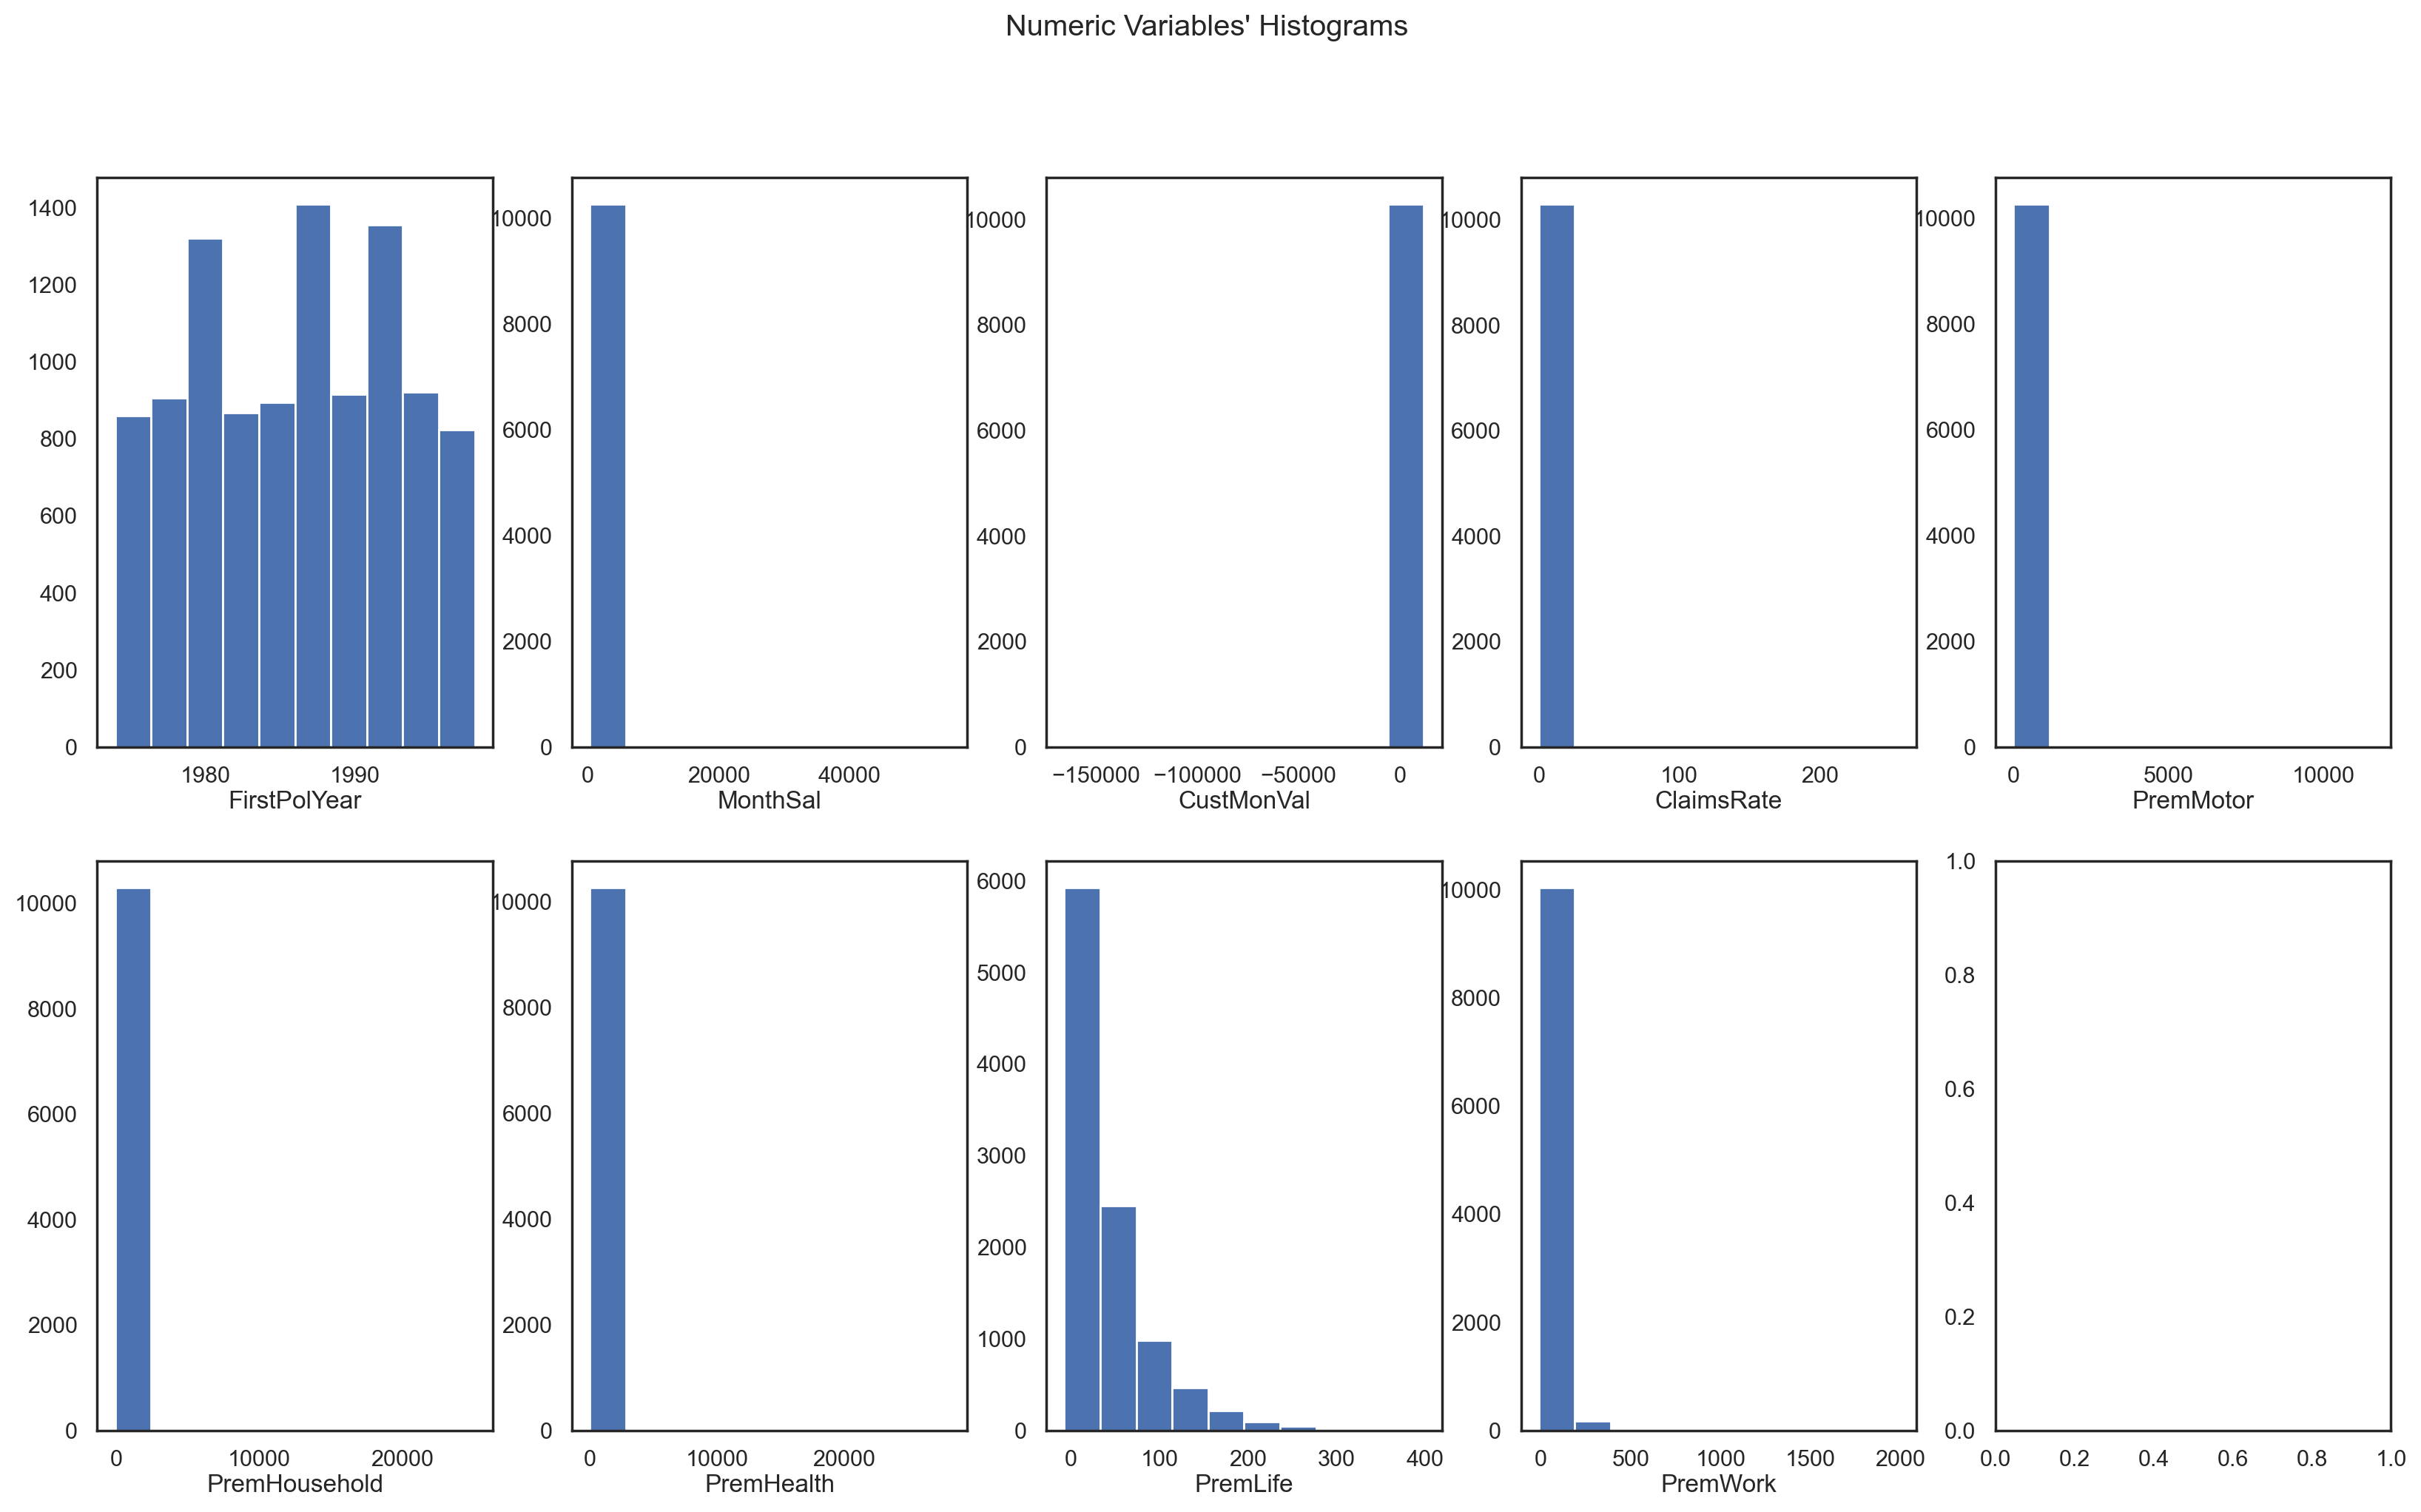

In [14]:
sns.set_style("white")

# Prepare figure. Create individual axes where each histogram will be placed
fig, axes = plt.subplots(2, ceil(len(metric_features) / 2), figsize=(20, 11))

# Plot data
# Iterate across axes objects and associate each histogram (hint: use the ax.hist() instead of plt.hist()):
for ax, feat in zip(axes.flatten(), metric_features): # Notice the zip() function and flatten() method
    ax.hist(df[feat][~np.isnan(df[feat])], bins=10)  
    ax.set_title(feat, y=-0.13)
    
# Layout
# Add a centered title to the figure:
title = "Numeric Variables' Histograms"

plt.suptitle(title)

### Numeric Variables' Box Plots

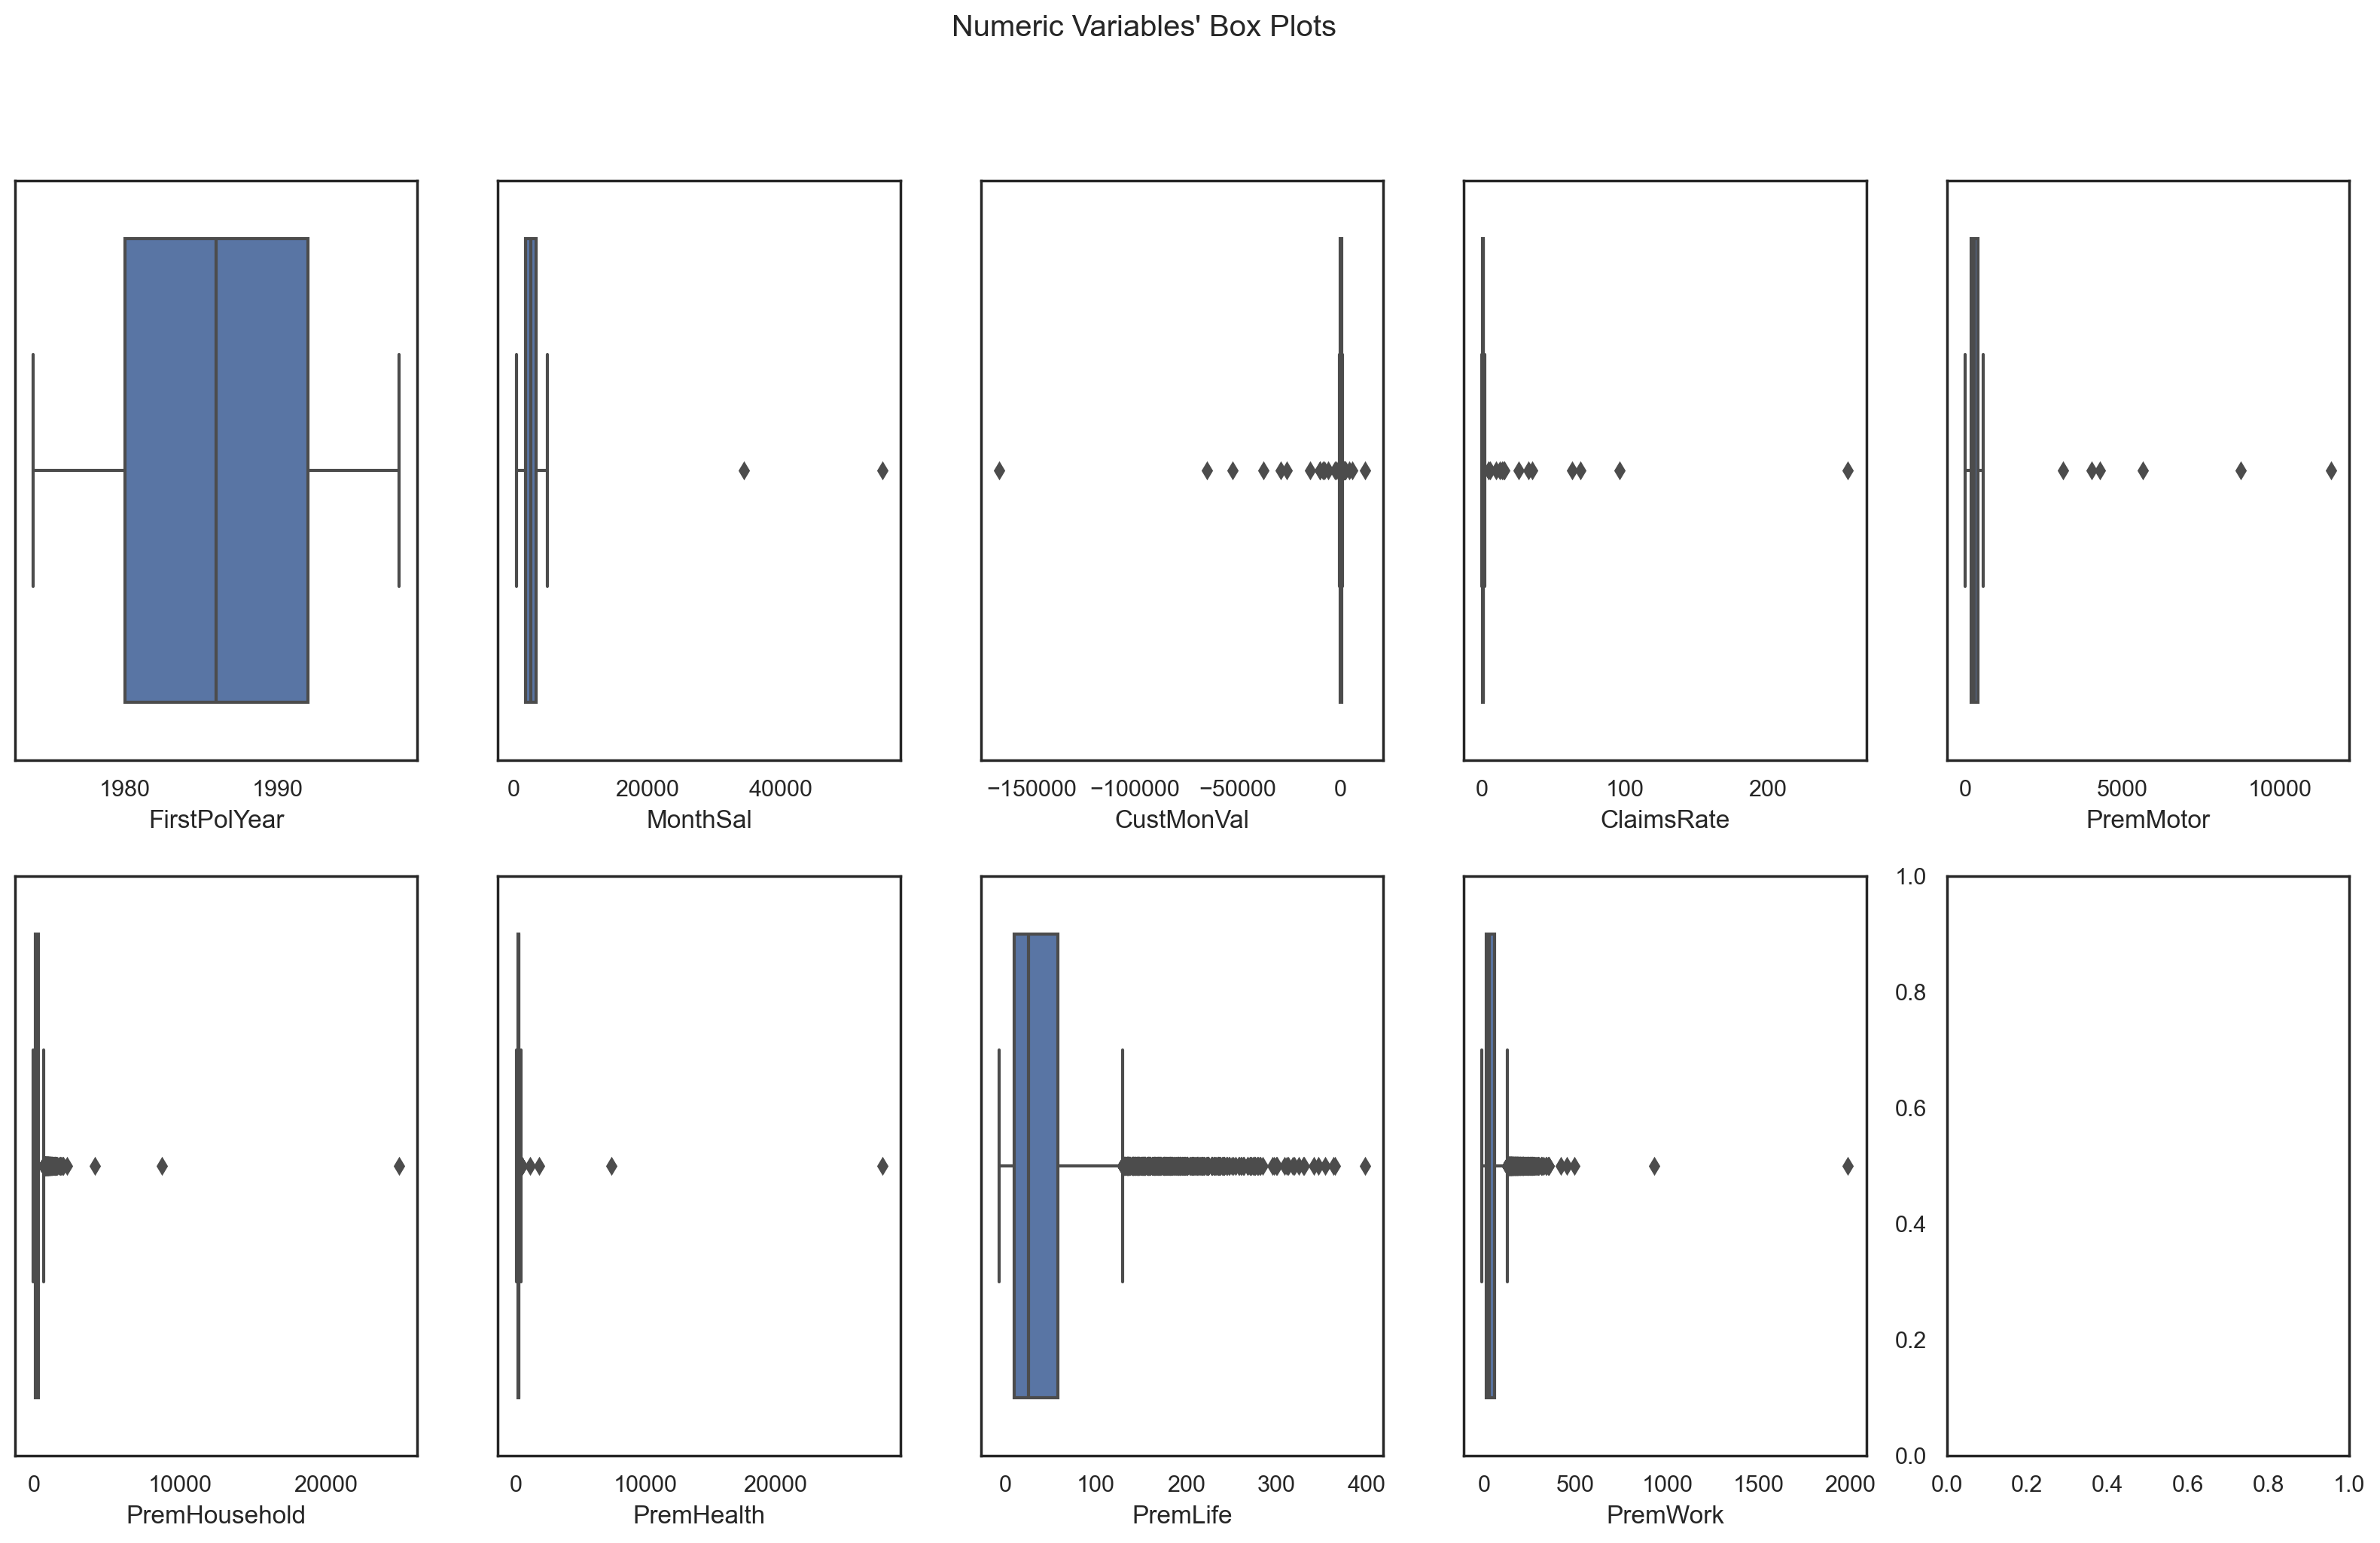

In [15]:
# All Numeric Variables' Box Plots in one figure
sns.set_style("white")

# Prepare figure. Create individual axes where each box plot will be placed
fig, axes = plt.subplots(2, ceil(len(metric_features) / 2), figsize=(20, 11))

# Plot data
# Iterate across axes objects and associate each box plot (hint: use the ax argument):
for ax, feat in zip(axes.flatten(), metric_features): # Notice the zip() function and flatten() method
    sns.boxplot(x=df[feat], ax=ax)
    
# Layout
# Add a centered title to the figure:
title = "Numeric Variables' Box Plots"

plt.suptitle(title)

#plt.savefig(os.path.join('..\DataMining_project_master.git/figures', 'box_plot_with_out'), dpi=200)
plt.show()

Possible Manual Outlier Removal Count

In [16]:
df_outliers =  df[df.notna()]
               
removal_index= ['MonthSal','CustMonVal','CustMonVal2','ClaimsRate','PremMotor','PremHousehold','PremHealth','PremLife','PremWork']
               
oulier_ciunt = []

unique, count = np.unique((df_outliers['MonthSal']<=20000), return_counts=True)

oulier_ciunt.append(count[0])

unique, count = np.unique((df_outliers['CustMonVal']>=-1250), return_counts=True)

oulier_ciunt.append(count[0])

unique, count = np.unique((df_outliers['CustMonVal']<1500), return_counts=True)

oulier_ciunt.append(count[0])

unique, count = np.unique((df_outliers['ClaimsRate']<=4), return_counts=True)

oulier_ciunt.append(count[0])

unique, count = np.unique((df['PremMotor']<=2000)| (df['PremMotor'].isnull()), return_counts=True)

oulier_ciunt.append(count[0])

unique, count = np.unique((df['PremHousehold']<=1600)| (df['PremHousehold'].isnull()), return_counts=True)

oulier_ciunt.append(count[0])

unique, count = np.unique((df['PremHealth']<=800)| (df['PremHealth'].isnull()), return_counts=True)

oulier_ciunt.append(count[0])

unique, count = np.unique((df['PremLife']<=300)| (df['PremLife'].isnull()), return_counts=True)

oulier_ciunt.append(count[0])

unique, count = np.unique((df['PremWork']<=400)| (df['PremWork'].isnull()), return_counts=True)

oulier_ciunt.append(count[0])

OuliersCountdf_outliers = pd.DataFrame(oulier_ciunt, index=removal_index, columns=['OutlierCount'])

OuliersCountdf_outliers

OutlierCount
MonthSal                 38
CustMonVal               14
CustMonVal2              12
ClaimsRate               15
PremMotor                 6
PremHousehold            12
PremHealth                4
PremLife                 15
PremWork                  5

### Categorical Cardinality Variables' Absolute Frequencies

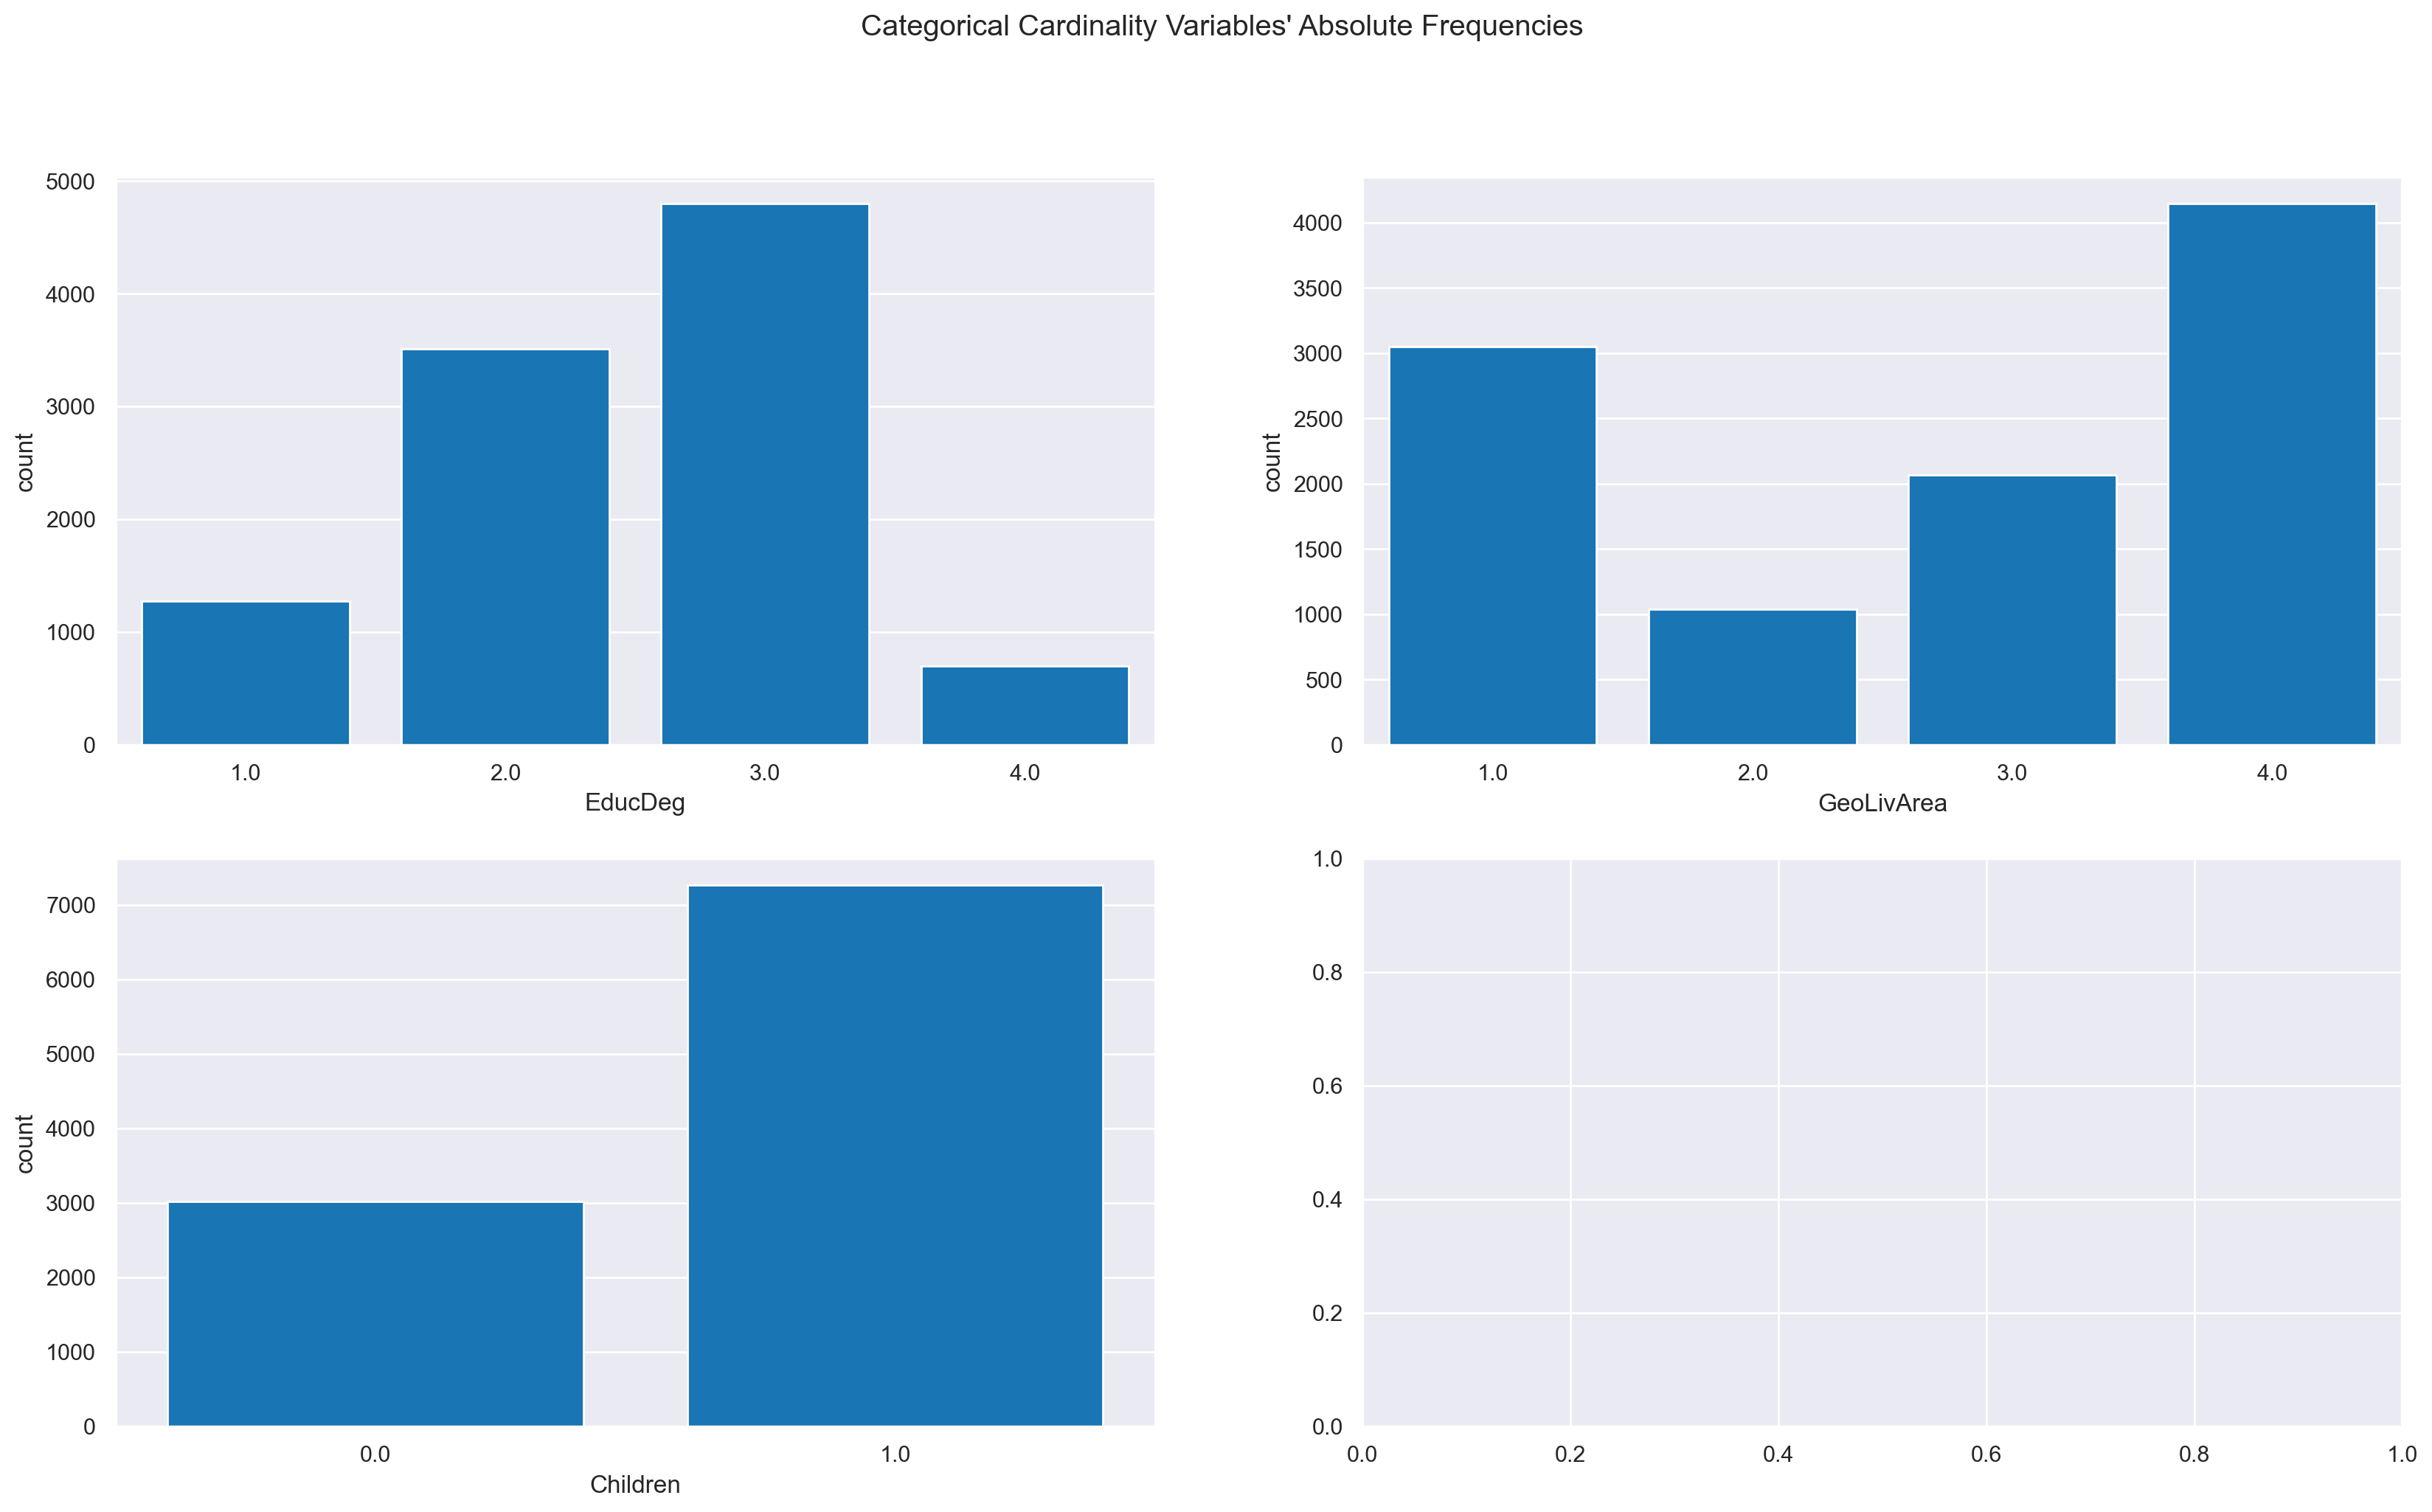

In [17]:
# All Non-Metric Variables' Absolute Frequencies
sns.set()

# Prepare figure. Create individual axes where each bar plot will be placed
fig, axes = plt.subplots(2, ceil(len(non_metric_features) / 2), figsize=(20, 11))

# Plot data
# Iterate across axes objects and associate each bar plot (hint: use the ax argument):
for ax, feat in zip(axes.flatten(), non_metric_features): # Notice the zip() function and flatten() method
    sns.countplot(x=df[feat].astype(object), ax=ax, color='#007acc')

title = "Categorical Cardinality Variables' Absolute Frequencies"
plt.suptitle(title)

plt.show()

# Outlier Removal

## Manuel Removal

In [18]:
filters1 = (
    ((df['FirstPolYear']<2017) | (df['FirstPolYear'].isnull()))
    &
    ((df['FirstPolYear']!=0) | (df['FirstPolYear'].isnull()))
    &
    ((df['MonthSal']<=10000) | (df['MonthSal'].isnull()))
    &
    ((df['CustMonVal']>=-1250) | (df['CustMonVal'].isnull()))
    &
    ((df['CustMonVal']<1500) | (df['CustMonVal'].isnull()))
    &
    ((df['ClaimsRate']<=4)| (df['ClaimsRate'].isnull()))
    &
    ((df['PremMotor']<=2000)| (df['PremMotor'].isnull()))
    &
    ((df['PremHousehold']<=1600)| (df['PremHousehold'].isnull()))
    &
    ((df['PremHealth']<=800)| (df['PremHealth'].isnull()))
    &
    ((df['PremLife']<=300)| (df['PremLife'].isnull()))
    &
    ((df['PremWork']<=400)| (df['PremWork'].isnull()))   
    
)

df_1 = df[filters1]

print('Percentage of data kept after removing outliers:', np.round(df_1.shape[0] / df.shape[0], 4))

Percentage of data kept after removing outliers: 0.9945


## Local Outlier Factor Filter

In [19]:

df_loc_outl_filters = df.dropna()
df_loc_outl_nans = df[df.isna().any(axis=1)]

lof = LocalOutlierFactor(n_jobs=-1)
yhat = lof.fit_predict(df_loc_outl_filters[metric_features].values)

# select all rows that are not outliers
mask = yhat != -1

outliers = df_loc_outl_filters.iloc[~mask, :].copy()

# variable that contains the original number of observations:
original_observation = df.dropna().shape[0]
df_loc_outl_filters = df_loc_outl_filters.drop(index=outliers.index)
print('Percentage of data kept after removing outliers:', np.round(df_loc_outl_filters.shape[0] / original_observation, 4))

Percentage of data kept after removing outliers: 0.9908


## IQR Method

In [20]:
# Train
df_iqr = df.dropna()

q25 = df_iqr[metric_features].quantile(.25)
q75 = df_iqr[metric_features].quantile(.75)
iqr = (q75 - q25)

upper_lim = q75 + 1.5 * iqr
lower_lim = q25 - 1.5 * iqr

filters = []
for metric in metric_features:
    llim = lower_lim[metric]
    ulim = upper_lim[metric]
    filters.append(df_iqr[metric].between(llim, ulim, inclusive='both'))

df_iqr = df_iqr[np.all(filters, 0)]

print('Percentage of data kept after removing outliers:', np.round(df_iqr.shape[0] / df.shape[0], 4))

Percentage of data kept after removing outliers: 0.833


## DBSCAN

[5.46361208e+01 5.68402437e+01 5.74057401e+01 ... 5.21033093e+04
 6.45515507e+04 1.65299132e+05]


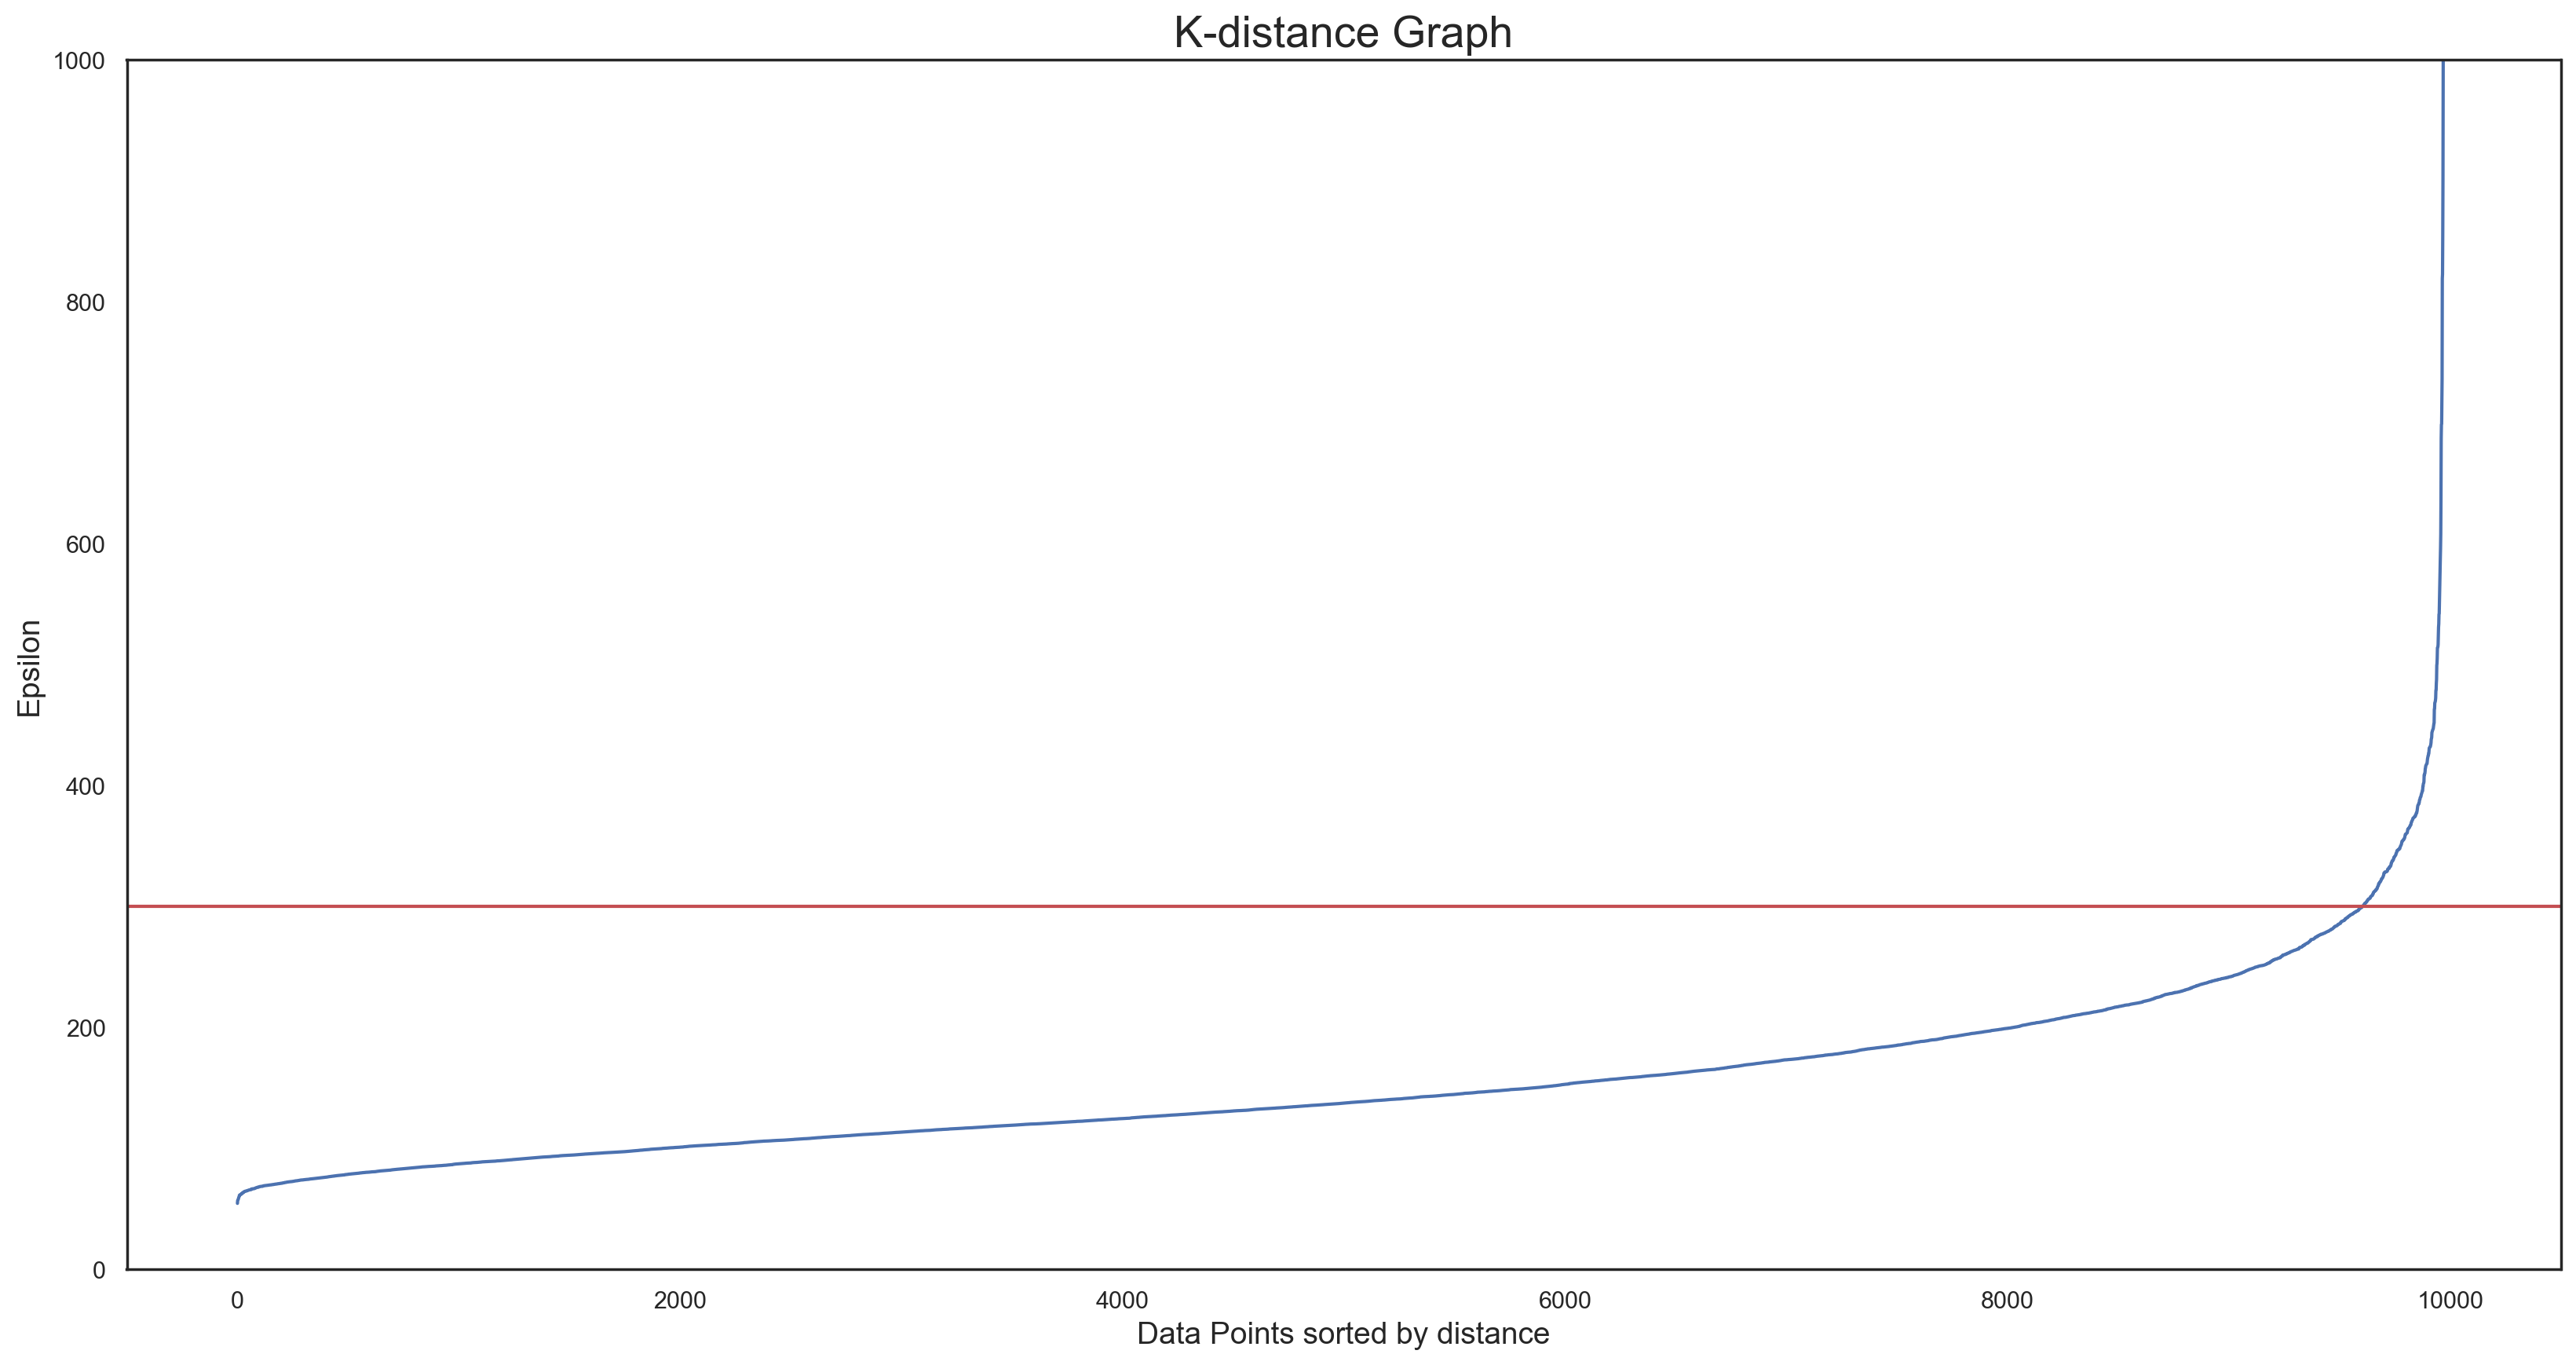

In [21]:
df_dbscan = df.dropna()

neigh = NearestNeighbors(n_neighbors = 20)
nbrs = neigh.fit(df_dbscan[metric_features])
distances, indices = nbrs.kneighbors(df_dbscan[metric_features])

%matplotlib inline
sns.set_style("white")
distances1 =  np.sort(distances[:, -1])
print(distances1)
plt.figure(figsize=(20,10))
plt.plot(distances1)
plt.ylim(0,1000)
plt.title('K-distance Graph',fontsize=20)
plt.xlabel('Data Points sorted by distance',fontsize=14)
plt.ylabel('Epsilon',fontsize=14)
plt.axhline(y=300, color='r', linestyle='-')
# plt.xlim([8000, 11000])
# plt.ylim([0, 2500])
plt.show()

In [22]:
dbscan = DBSCAN(eps = 300)

model = dbscan.fit(df_dbscan[metric_features])

labels = model.labels_

df_dbscan["anomaly_score"] = labels

df_dbscan_test = df_dbscan[df_dbscan["anomaly_score"] != -1]

print('Percentage of data kept after removing outliers:', np.round(df_dbscan_test.shape[0] / df.shape[0], 4))

Percentage of data kept after removing outliers: 0.9664


/var/folders/m4/8977wlvx6jxcc9wy9vbvpjbm0000gn/T/ipykernel_11402/484581653.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dbscan["anomaly_score"] = labels


Although the Manual Removal and DSCAN we're pretty close, we decided to go with Local Outlier Factor Removal since it's closer to the 2-3% optimun.

In [23]:
df = df_1

## Missing Value Processing

In [24]:
df.isna().sum()

FirstPolYear      30
EducDeg           17
MonthSal          36
GeoLivArea         1
Children          21
CustMonVal         0
ClaimsRate         0
PremMotor         33
PremHousehold      0
PremHealth        42
PremLife         104
PremWork          86
dtype: int64

### Enteprise Generated Data

In [25]:
EGD = ['PremMotor','PremHousehold','PremHealth','PremLife','PremWork']

In [26]:
for column in EGD:
    index = list(df[df[column].isnull()].index)
    for i in index:
        df.loc[i,column]=0
    

### Client Generated Data

#### Geographic Living Area

In [27]:
mode_GeoLivArea = df['GeoLivArea'].mode().loc[0]
df['GeoLivArea'].fillna(mode_GeoLivArea, inplace=True)

#### Educ Deg

In [28]:
def weighted_hamming(data):
    """ Compute weighted hamming distance on categorical variables. For one variable, it is equal to 1 if
        the values between point A and point B are different, else it is equal the relative frequency of the
        distribution of the value across the variable. For multiple variables, the harmonic mean is computed
        up to a constant factor.
        @params:
            - data = a pandas data frame of categorical variables
        @returns:
            - distance_matrix = a distance matrix with pairwise distance for all attributes
    """
    categories_dist = []
    
    for category in data:
        X = pd.get_dummies(data[category])
        X_mean = X * X.mean()
        X_dot = X_mean.dot(X.transpose())
        X_np = np.asarray(X_dot.replace(0,1,inplace=False))
        categories_dist.append(X_np)
    categories_dist = np.array(categories_dist)
    distances = hmean(categories_dist, axis=0)
    return distances


def distance_matrix(data, numeric_distance = "euclidean", categorical_distance = "jaccard"):
    """ Compute the pairwise distance attribute by attribute in order to account for different variables type:
        - Continuous
        - Categorical
        For ordinal values, provide a numerical representation taking the order into account.
        Categorical variables are transformed into a set of binary ones.
        If both continuous and categorical distance are provided, a Gower-like distance is computed and the numeric
        variables are all normalized in the process.
        If there are missing values, the mean is computed for numerical attributes and the mode for categorical ones.
        
        Note: If weighted-hamming distance is chosen, the computation time increases a lot since it is not coded in C 
        like other distance metrics provided by scipy.
        @params:
            - data                  = pandas dataframe to compute distances on.
            - numeric_distances     = the metric to apply to continuous attributes.
                                      "euclidean" and "cityblock" available.
                                      Default = "euclidean"
            - categorical_distances = the metric to apply to binary attributes.
                                      "jaccard", "hamming", "weighted-hamming" and "euclidean"
                                      available. Default = "jaccard"
        @returns:
            - the distance matrix
    """
    possible_continuous_distances = ["euclidean", "cityblock"]
    possible_binary_distances = ["euclidean", "jaccard", "hamming", "weighted-hamming"]
    number_of_variables = data.shape[1]
    number_of_observations = data.shape[0]

    # Get the type of each attribute (Numeric or categorical)
    is_numeric = [all(isinstance(n, numbers.Number) for n in data.iloc[:, i]) for i, x in enumerate(data)]
    is_all_numeric = sum(is_numeric) == len(is_numeric)
    is_all_categorical = sum(is_numeric) == 0
    is_mixed_type = not is_all_categorical and not is_all_numeric

    # Check the content of the distances parameter
    if numeric_distance not in possible_continuous_distances:
        print ("The continuous distance " + numeric_distance + " is not supported.")
        return None
    elif categorical_distance not in possible_binary_distances:
        print ("The binary distance " + categorical_distance + " is not supported.")
        return None

    # Separate the data frame into categorical and numeric attributes and normalize numeric data
    if is_mixed_type:
        number_of_numeric_var = sum(is_numeric)
        number_of_categorical_var = number_of_variables - number_of_numeric_var
        data_numeric = data.iloc[:, is_numeric]
        data_numeric = (data_numeric - data_numeric.mean()) / (data_numeric.max() - data_numeric.min())
        data_categorical = data.iloc[:, [not x for x in is_numeric]]

    # Replace missing values with column mean for numeric values and mode for categorical ones. With the mode, it
    # triggers a warning: "SettingWithCopyWarning: A value is trying to be set on a copy of a slice from a DataFrame"
    # but the value are properly replaced
    if is_mixed_type:
        data_numeric.fillna(data_numeric.mean(), inplace=True)
        for x in data_categorical:
            data_categorical[x].fillna(data_categorical[x].mode()[0], inplace=True)
    elif is_all_numeric:
        data.fillna(data.mean(), inplace=True)
    else:
        for x in data:
            data[x].fillna(data[x].mode()[0], inplace=True)

    # "Dummifies" categorical variables in place
    if not is_all_numeric and not (categorical_distance == 'hamming' or categorical_distance == 'weighted-hamming'):
        if is_mixed_type:
            data_categorical = pd.get_dummies(data_categorical)
        else:
            data = pd.get_dummies(data)
    elif not is_all_numeric and categorical_distance == 'hamming':
        if is_mixed_type:
            data_categorical = pd.DataFrame([pd.factorize(data_categorical[x])[0] for x in data_categorical]).transpose()
        else:
            data = pd.DataFrame([pd.factorize(data[x])[0] for x in data]).transpose()

    if is_all_numeric:
        result_matrix = cdist(data, data, metric=numeric_distance)
    elif is_all_categorical:
        if categorical_distance == "weighted-hamming":
            result_matrix = weighted_hamming(data)
        else:
            result_matrix = cdist(data, data, metric=categorical_distance)
    else:
        result_numeric = cdist(data_numeric, data_numeric, metric=numeric_distance)
        if categorical_distance == "weighted-hamming":
            result_categorical = weighted_hamming(data_categorical)
        else:
            result_categorical = cdist(data_categorical, data_categorical, metric=categorical_distance)
        result_matrix = np.array([[1.0*(result_numeric[i, j] * number_of_numeric_var + result_categorical[i, j] *
                               number_of_categorical_var) / number_of_variables for j in range(number_of_observations)] for i in range(number_of_observations)])

    # Fill the diagonal with NaN values
    np.fill_diagonal(result_matrix, np.nan)

    return pd.DataFrame(result_matrix)


def knn_impute(target, attributes, k_neighbors, aggregation_method="mean", numeric_distance="euclidean",
               categorical_distance="jaccard", missing_neighbors_threshold = 0.5):
    """ Replace the missing values within the target variable based on its k nearest neighbors identified with the
        attributes variables. If more than 50% of its neighbors are also missing values, the value is not modified and
        remains missing. If there is a problem in the parameters provided, returns None.
        If to many neighbors also have missing values, leave the missing value of interest unchanged.
        @params:
            - target                        = a vector of n values with missing values that you want to impute. The length has
                                              to be at least n = 3.
            - attributes                    = a data frame of attributes with n rows to match the target variable
            - k_neighbors                   = the number of neighbors to look at to impute the missing values. It has to be a
                                              value between 1 and n.
            - aggregation_method            = how to aggregate the values from the nearest neighbors (mean, median, mode)
                                              Default = "mean"
            - numeric_distances             = the metric to apply to continuous attributes.
                                              "euclidean" and "cityblock" available.
                                              Default = "euclidean"
            - categorical_distances         = the metric to apply to binary attributes.
                                              "jaccard", "hamming", "weighted-hamming" and "euclidean"
                                              available. Default = "jaccard"
            - missing_neighbors_threshold   = minimum of neighbors among the k ones that are not also missing to infer
                                              the correct value. Default = 0.5
        @returns:
            target_completed        = the vector of target values with missing value replaced. If there is a problem
                                      in the parameters, return None
    """

    # Get useful variables
    possible_aggregation_method = ["mean", "median", "mode"]
    number_observations = len(target)
    is_target_numeric = all(isinstance(n, numbers.Number) for n in target)

    # Check for possible errors
    if number_observations < 3:
        print ("Not enough observations.")
        return None
    if attributes.shape[0] != number_observations:
        print ( "The number of observations in the attributes variable is not matching the target variable length.")
        return None
    if k_neighbors > number_observations or k_neighbors < 1:
        print ("The range of the number of neighbors is incorrect.")
        return None
    if aggregation_method not in possible_aggregation_method:
        print ("The aggregation method is incorrect.")
        return None
    if not is_target_numeric and aggregation_method != "mode":
        print ("The only method allowed for categorical target variable is the mode.")
        return None

    # Make sure the data are in the right format
    target = pd.DataFrame(target)
    attributes = pd.DataFrame(attributes)

    # Get the distance matrix and check whether no error was triggered when computing it
    distances = distance_matrix(attributes, numeric_distance, categorical_distance)
    if distances is None:
        return None

    # Get the closest points and compute the correct aggregation method
    for i, value in enumerate(target.iloc[:, 0]):
        if pd.isnull(value):
            order = distances.iloc[i,:].values.argsort()[:k_neighbors]
            closest_to_target = target.iloc[order, :]
            missing_neighbors = [x for x  in closest_to_target.isnull().iloc[:, 0]]
            # Compute the right aggregation method if at least more than 50% of the closest neighbors are not missing
            if sum(missing_neighbors) >= missing_neighbors_threshold * k_neighbors:
                continue
            elif aggregation_method == "mean":
                target.iloc[i] = np.ma.mean(np.ma.masked_array(closest_to_target,np.isnan(closest_to_target)))
            elif aggregation_method == "median":
                target.iloc[i] = np.ma.median(np.ma.masked_array(closest_to_target,np.isnan(closest_to_target)))
            else:
                target.iloc[i] = stats.mode(closest_to_target, nan_policy='omit')[0][0]

    return target

In [29]:
target =knn_impute(
    df['EducDeg'],
    df.drop(columns= 'EducDeg'),
    k_neighbors= 20,aggregation_method="mean",
    numeric_distance="euclidean",categorical_distance="jaccard",
    missing_neighbors_threshold = 0.5)

In [30]:
df['EducDeg']=target['EducDeg'].round()

### FirstPolYear

In [31]:
target =knn_impute(
    df['FirstPolYear'],
    df.drop(columns= 'FirstPolYear'),
    k_neighbors= 20,aggregation_method="mean",
    numeric_distance="euclidean",categorical_distance="jaccard",
    missing_neighbors_threshold = 0.5)

In [32]:
df['FirstPolYear']=target['FirstPolYear'].round()

### Month Sal

In [33]:
target =knn_impute(
    df['MonthSal'],
    df.drop(columns= 'MonthSal'),
    k_neighbors= 20,aggregation_method="mean",
    numeric_distance="euclidean",categorical_distance="jaccard",
    missing_neighbors_threshold = 0.5)

In [34]:
df['MonthSal']=target['MonthSal'].round()

### Children

In [35]:
lr = LogisticRegression()

df.head()

testdf = df[df['Children'].isnull()==True]

traindf = df[df['Children'].isnull()==False]

y = traindf['Children']
y_test = testdf['Children']

traindf = traindf.drop("Children",axis=1)

testdf = testdf.drop("Children",axis=1)


lr.fit(traindf,y)

LogisticRegression()

pred = list(lr.predict(testdf))

/Users/tomasdomingos/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [36]:
index= list(df[df['Children'].isnull()==True].index)

target = pd.DataFrame(pred,columns=['Children'],index=index)

In [37]:
for i in range(0,21):
    df.at[list(target.index)[i], 'Children']=list(np.array(target))[i]

In [38]:
df.isna().sum()

FirstPolYear     0
EducDeg          0
MonthSal         0
GeoLivArea       0
Children         0
CustMonVal       0
ClaimsRate       0
PremMotor        0
PremHousehold    0
PremHealth       0
PremLife         0
PremWork         0
dtype: int64

# Feature Extraction

## Customer Retention

In [39]:
#years as a Customer
df['Cust_Retention']=2016-df['FirstPolYear']

## Total of Premium

In [40]:
#years as a Customer
df['Prem_Total']=df['PremMotor']+df['PremHousehold']+df['PremHealth']+df['PremLife']+df['PremWork']

## Yearly Salary

In [41]:
#years as a Customer
df['Year_Sal']=df['MonthSal']*12

## Commitment Ratio

In [42]:
df['Commitment']=np.where(df['Year_Sal']==0, 0,np.divide(df['Prem_Total'],df['Year_Sal']))

## Premium Motor/Yearly Salary Ratio

In [43]:
df['Motor_Commitment']=np.where(df['Year_Sal']==0, 0,np.divide(df['PremMotor'],df['Year_Sal']))

## Premium Household/Yearly Salary Ratio

In [44]:
df['Houehold_Commitment']=np.where(df['Year_Sal']==0, 0,np.divide(df['PremHousehold'],df['Year_Sal']))

## Premium Health/Yearly Salary Ratio

In [45]:
df['Healthr_Commitment']=np.where(df['Year_Sal']==0, 0,np.divide(df['PremHealth'],df['Year_Sal']))

## Premium Life/Yearly Salary Ratio

In [46]:
df['Life_Commitment']=np.where(df['Year_Sal']==0, 0,np.divide(df['PremLife'],df['Year_Sal']))

## Premium Work/Yearly Salary Ratio

In [47]:
df['Work_Commitment']=np.where(df['Year_Sal']==0, 0,np.divide(df['PremWork'],df['Year_Sal']))

## Yearly Cost

Claims Rate = Paid by Insurance over 2year/Premiums paid over 2 years

Paid by Insurance over 2year = Claims Rate * Premiums paid over 2 years

In [48]:
df['Yearly_Cost']= df['ClaimsRate']*df['Prem_Total']

## Updating Metric Features List

In [49]:
feature_extraction= ['Cust_Retention',
                     'Prem_Total',
                     'Year_Sal',
                     'Commitment',
                     'Motor_Commitment',
                     'Houehold_Commitment',
                     'Healthr_Commitment',
                     'Life_Commitment',
                     'Work_Commitment',
                     'Yearly_Cost']

for i in feature_extraction:
    metric_features.append(i)

# MinMax Scaler

In [50]:
# MinMaxScaler
# create scaler using train data set
scaler = MinMaxScaler().fit(df[metric_features])

df_scaled = scaler.transform(df[metric_features]) # this will return an array
# Convert the array to a pandas dataframe
df_scaled = pd.DataFrame(df_scaled, columns = df[metric_features].columns).set_index(df.index)

In [51]:
df[metric_features]= df_scaled

# Redo Visual Exploration

Text(0.5, 0.98, "Numeric Variables' Histograms")

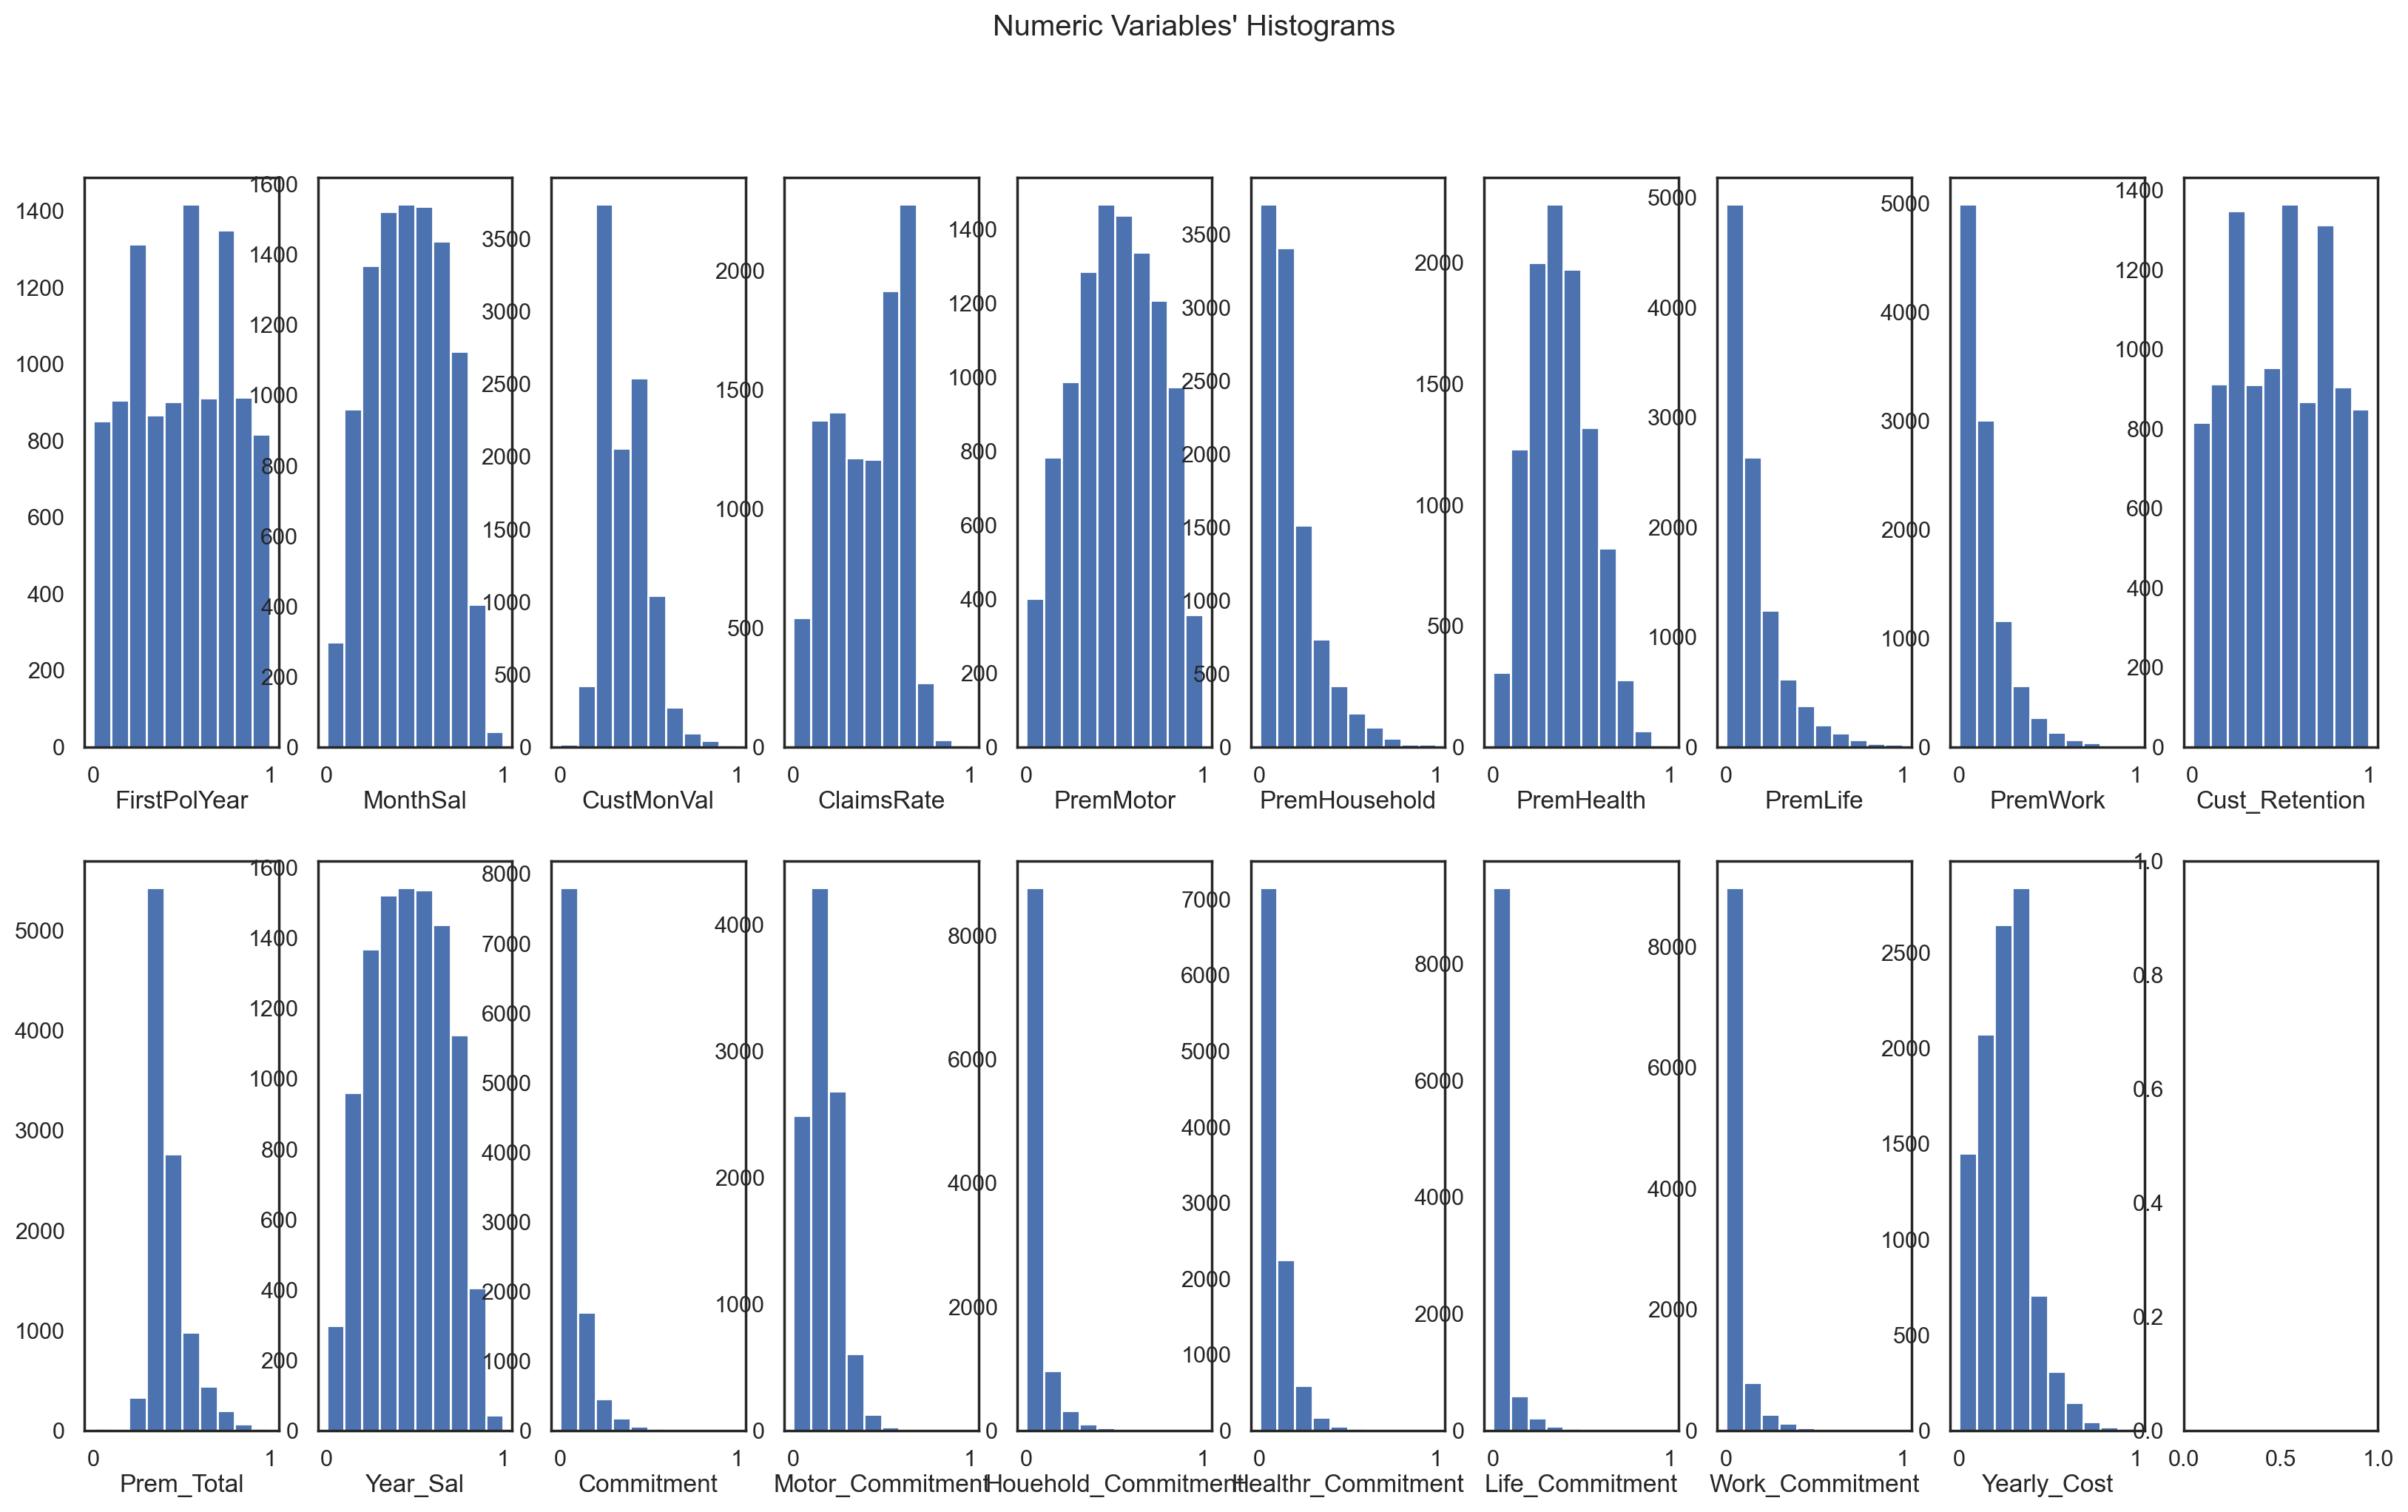

In [52]:
sns.set_style("white")

# Prepare figure. Create individual axes where each histogram will be placed
fig, axes = plt.subplots(2, ceil(len(metric_features) / 2), figsize=(20, 11))

# Plot data
# Iterate across axes objects and associate each histogram (hint: use the ax.hist() instead of plt.hist()):
for ax, feat in zip(axes.flatten(), metric_features): # Notice the zip() function and flatten() method
    ax.hist(df[feat][~np.isnan(df[feat])], bins=10)  
    ax.set_title(feat, y=-0.13)
    
# Layout
# Add a centered title to the figure:
title = "Numeric Variables' Histograms"

plt.suptitle(title)

### Numeric Variables' Box Plots

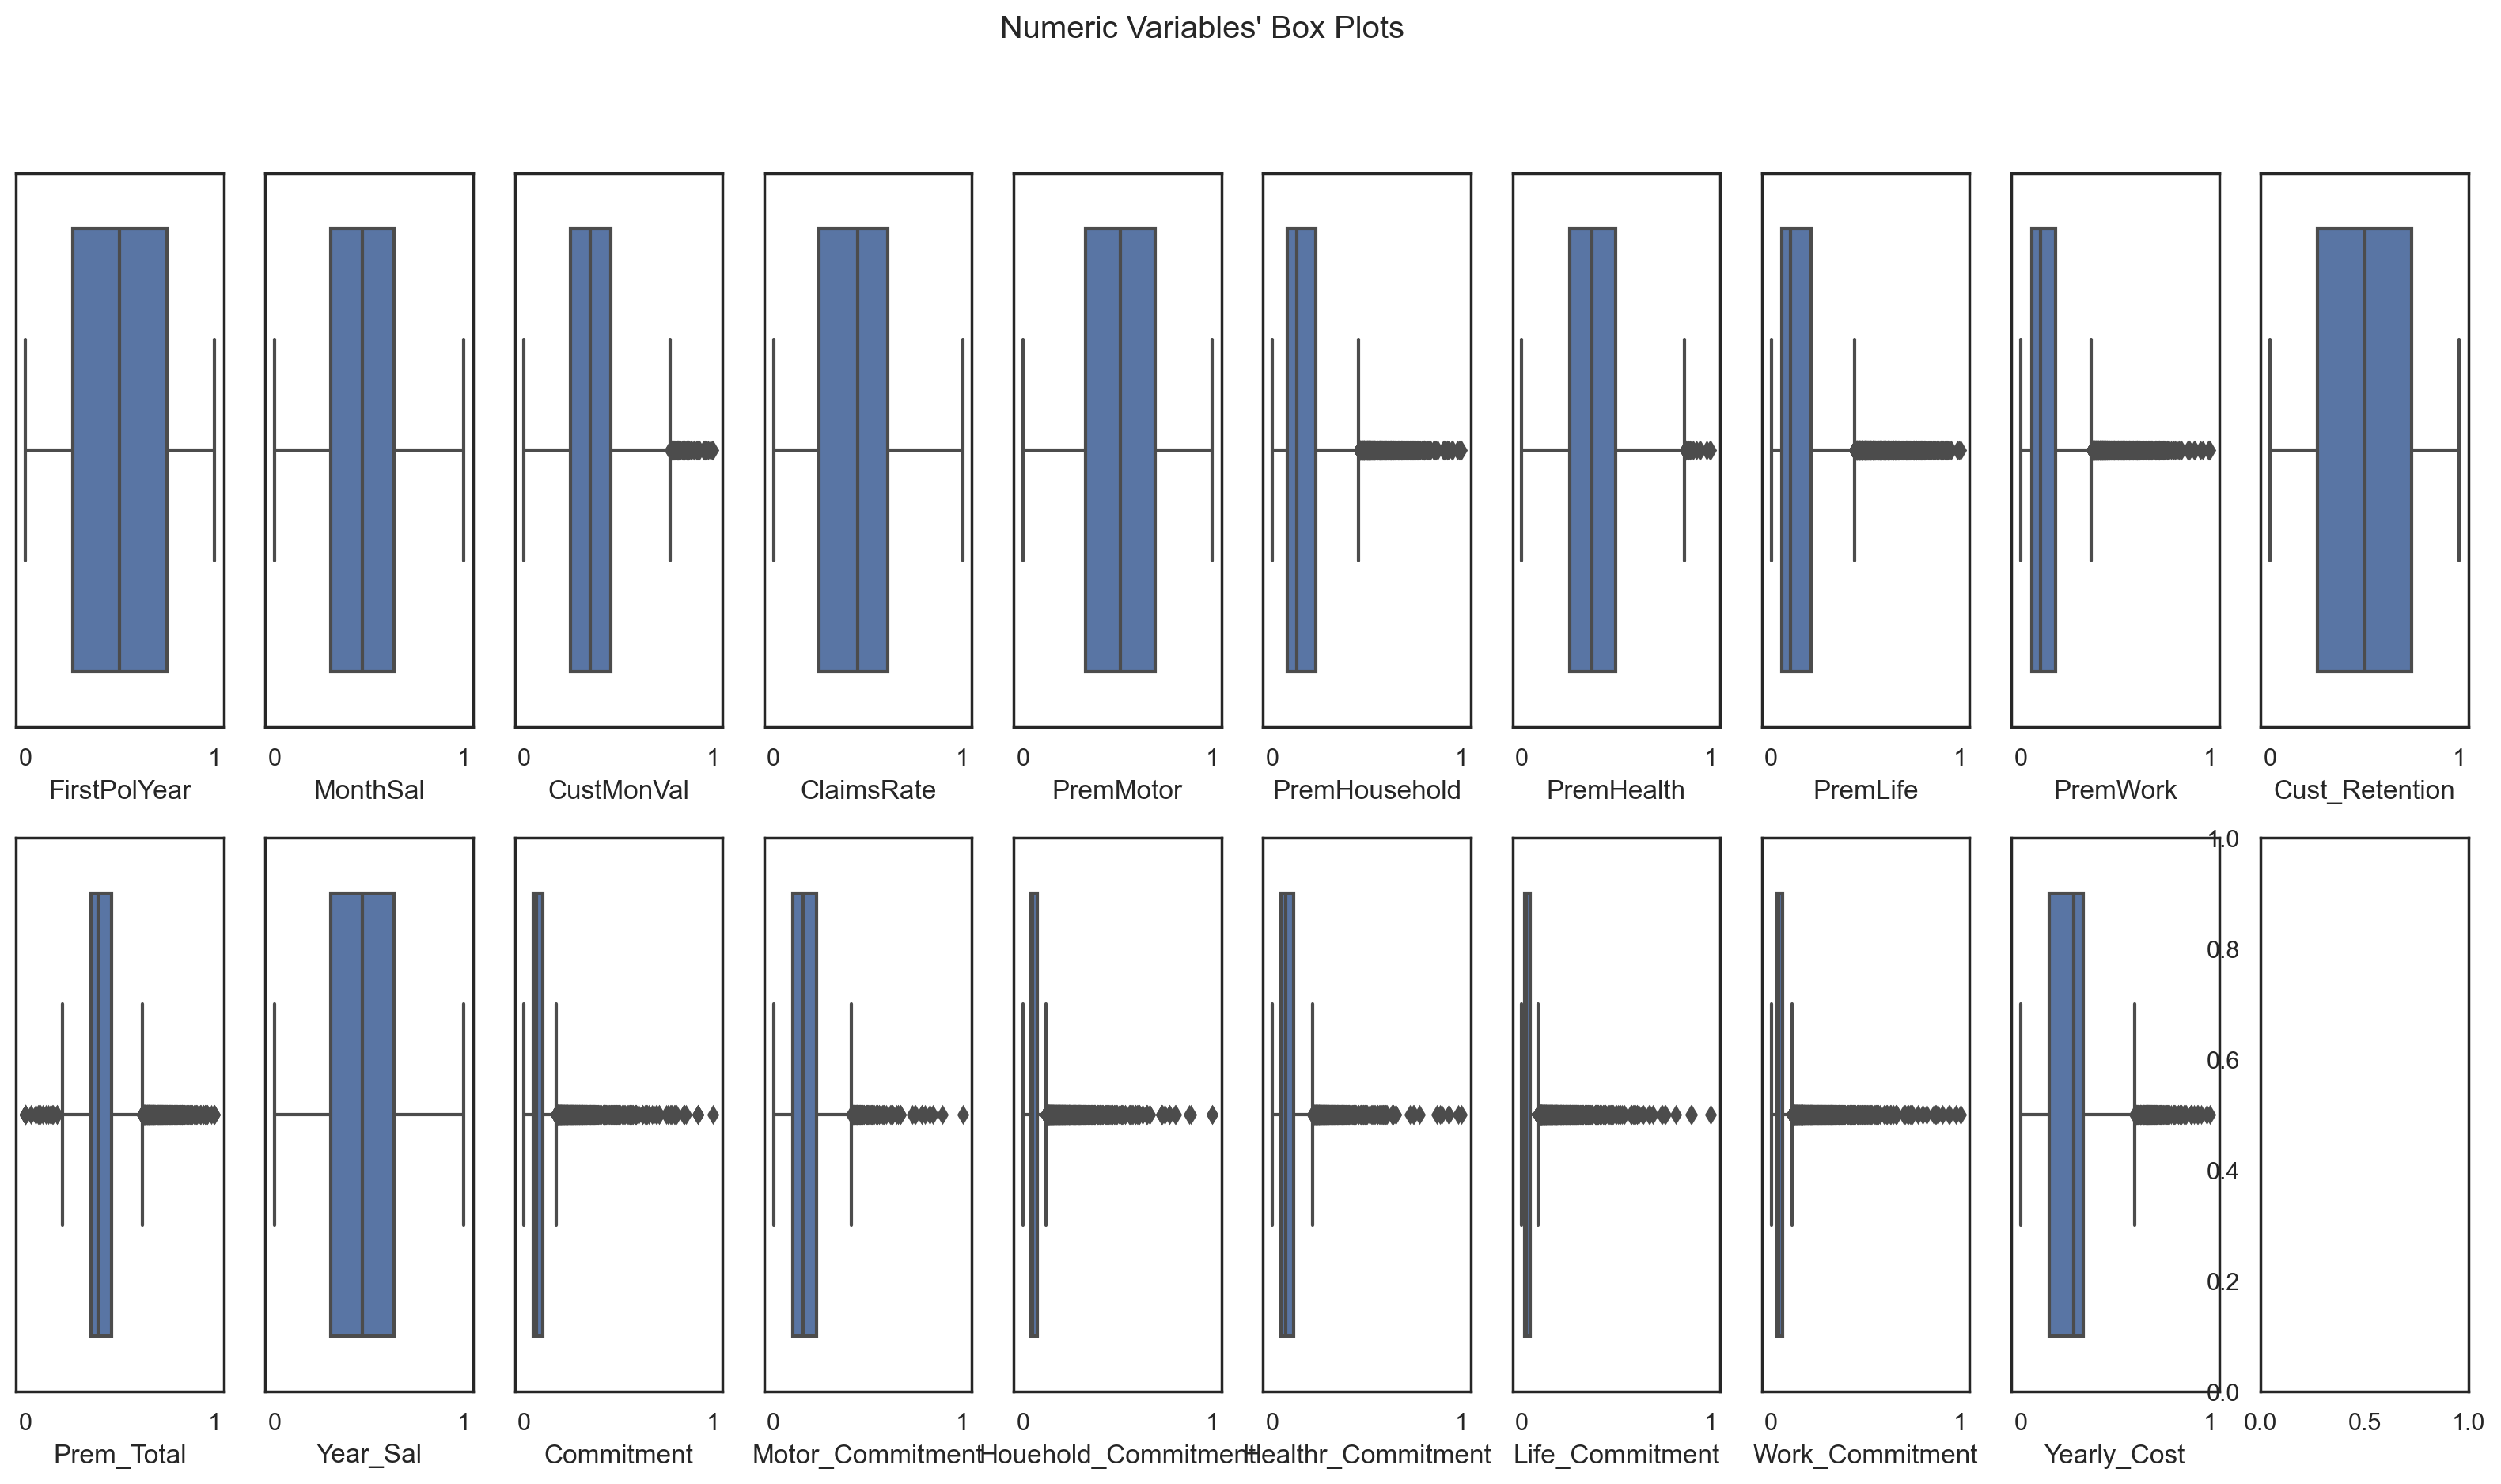

In [53]:
# All Numeric Variables' Box Plots in one figure
sns.set_style("white")

# Prepare figure. Create individual axes where each box plot will be placed
fig, axes = plt.subplots(2, ceil(len(metric_features) / 2), figsize=(20, 10))

# Plot data
# Iterate across axes objects and associate each box plot (hint: use the ax argument):
for ax, feat in zip(axes.flatten(), metric_features): # Notice the zip() function and flatten() method
    sns.boxplot(x=df[feat], ax=ax)
    
# Layout
# Add a centered title to the figure:
title = "Numeric Variables' Box Plots"

plt.suptitle(title)

#plt.savefig(os.path.join('..\DataMining_project_master.git/figures', 'box_plot_with_out'), dpi=200)
plt.show()

### Correlation Matrix

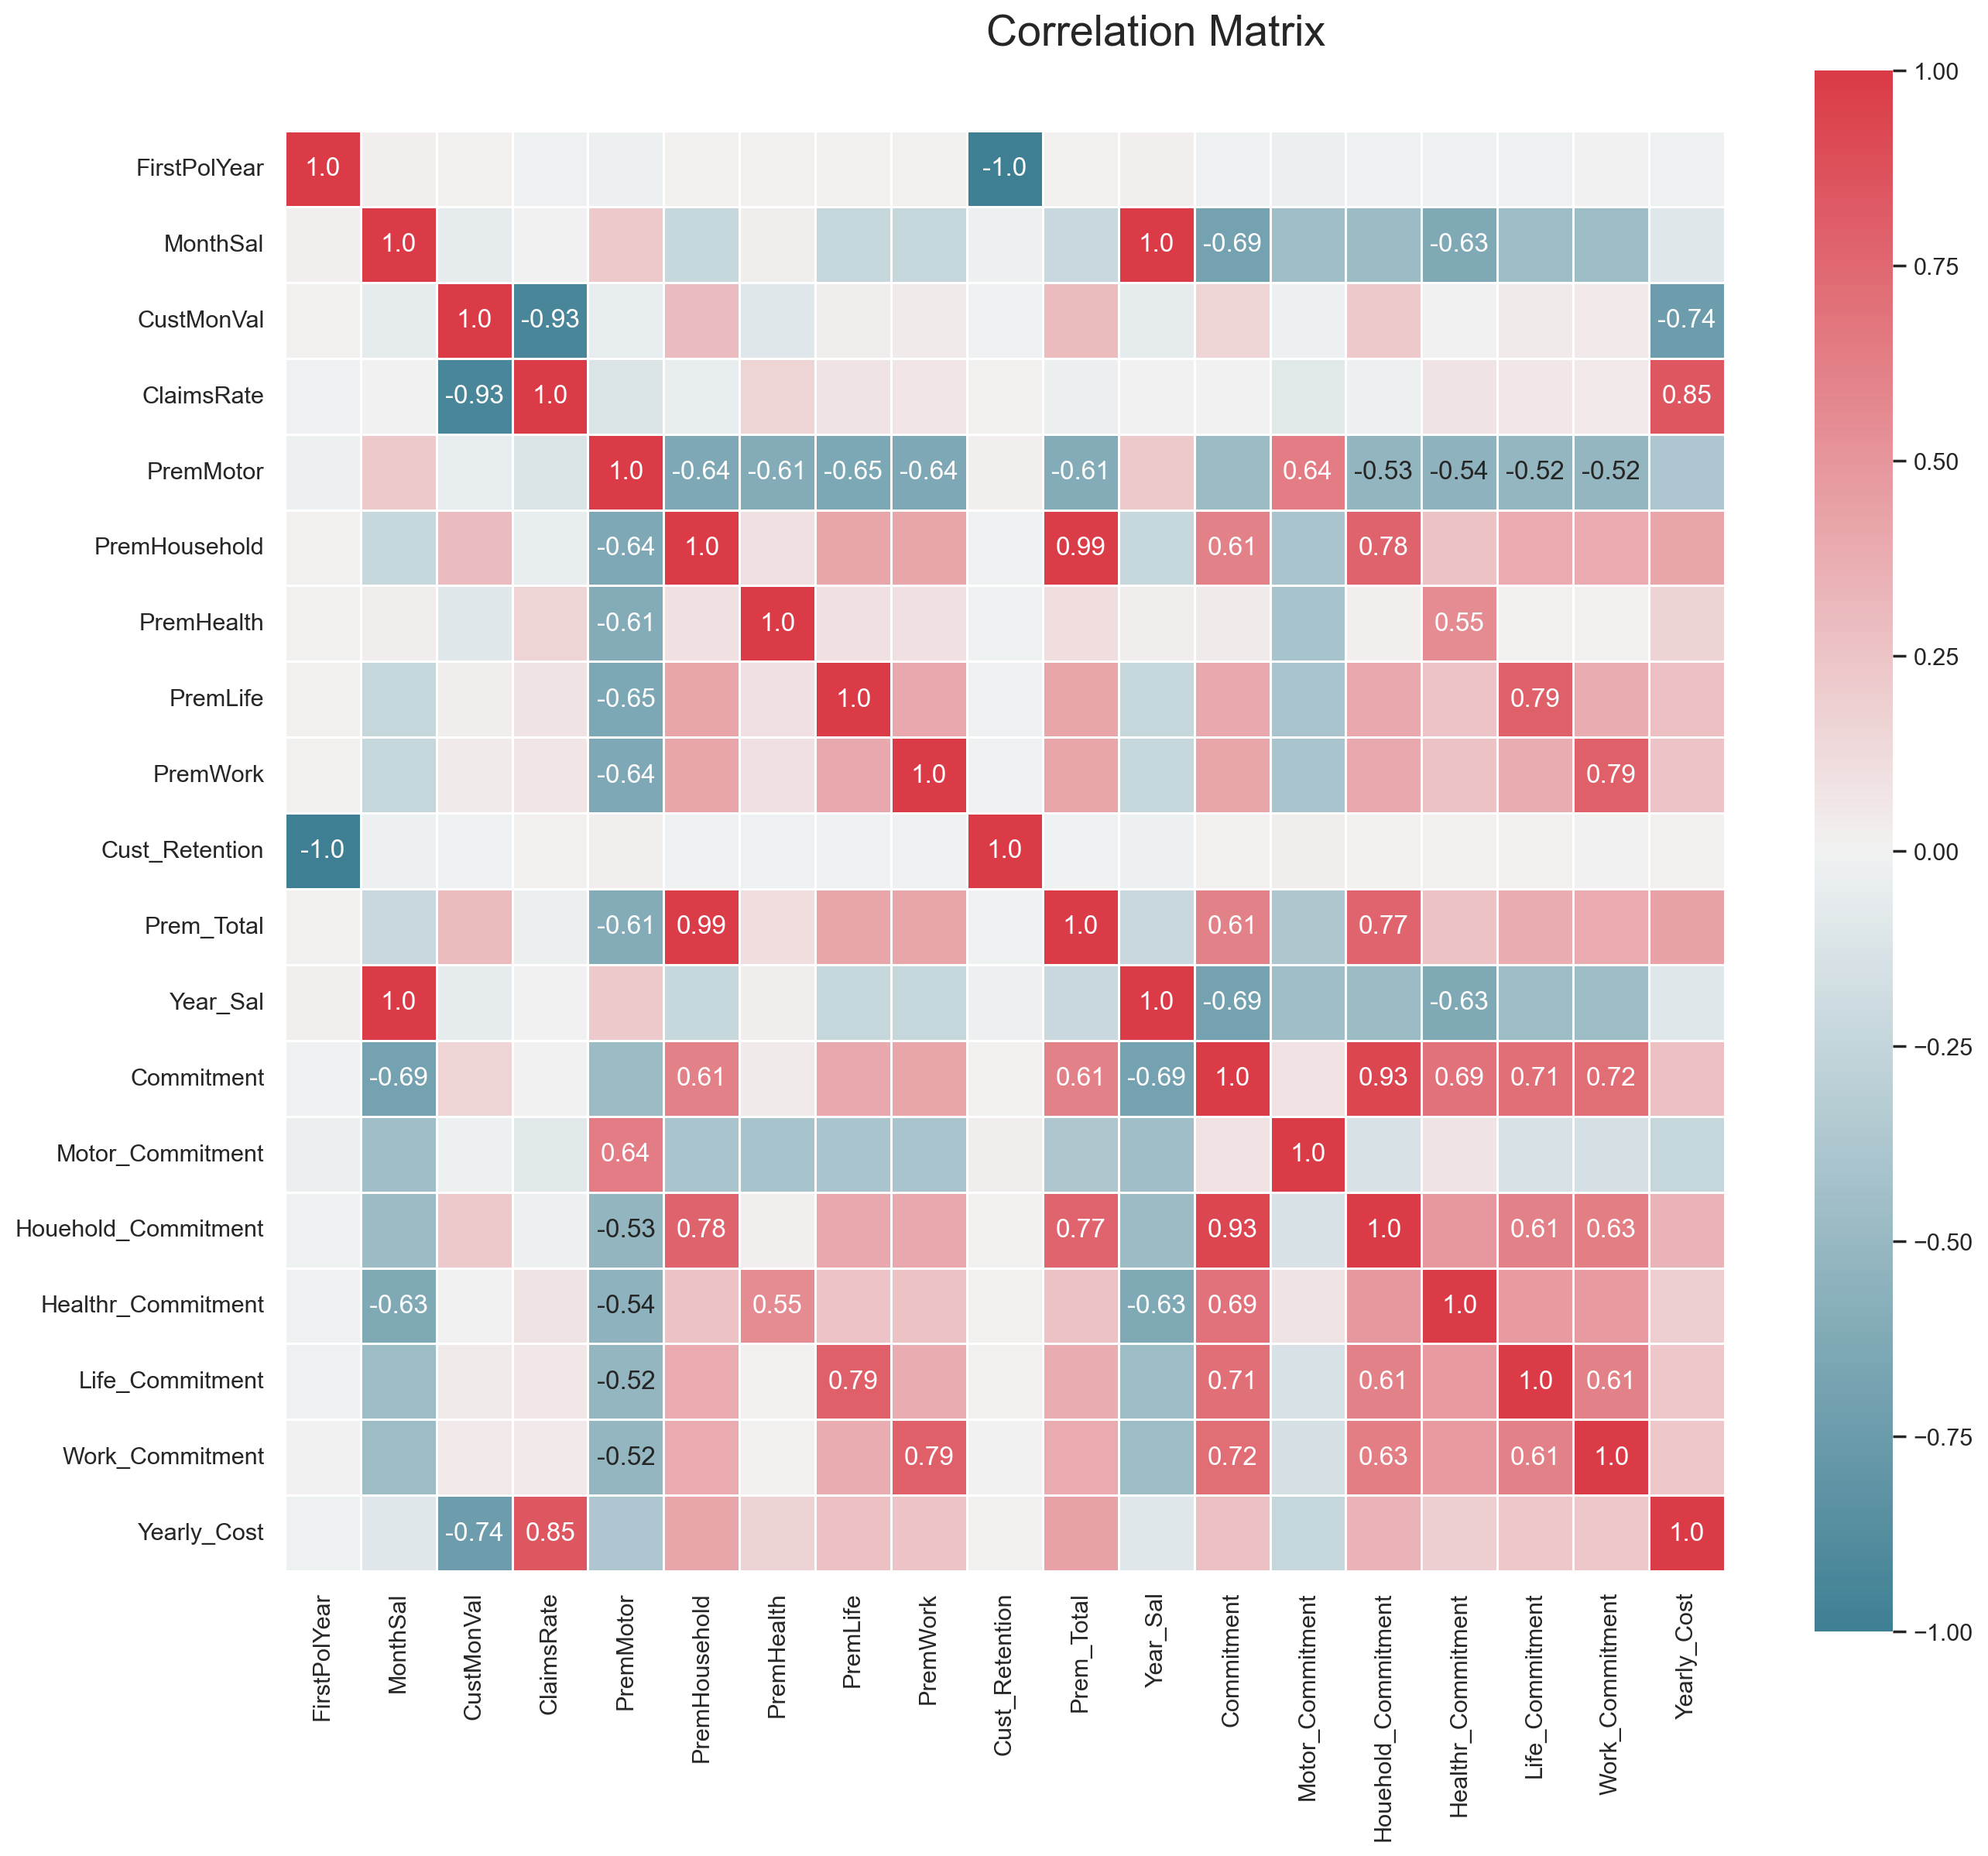

In [54]:
# Prepare figure
fig = plt.figure(figsize=(15, 12))

# Obtain correlation matrix. Round the values to 2 decimal cases. Use the DataFrame corr() and round() method.
corr = np.round(df[metric_features].corr(method="pearson"), decimals=2)

# Build annotation matrix (values above |0.5| will appear annotated in the plot)
mask_annot = np.absolute(corr.values) >= 0.5
annot = np.where(mask_annot, corr.values, np.full(corr.shape,"")) # Try to understand what this np.where() does

# Plot heatmap of the correlation matrix
sns.heatmap(data=corr, annot=annot, cmap=sns.diverging_palette(220, 10, as_cmap=True), 
            fmt='s', vmin=-1, vmax=1, center=0, square=True, linewidths=.5)

# Layout
fig.subplots_adjust(top=0.95)
fig.suptitle("Correlation Matrix", fontsize=20)

plt.savefig(os.path.join('..', 'figures', 'correlation_matrix.png'), dpi=200)

plt.show()

# Clustering by Perspectives
- Demographic/Behavioral Perspective:
- Product Perspective:

In [55]:
df.columns

Index(['FirstPolYear', 'EducDeg', 'MonthSal', 'GeoLivArea', 'Children',
       'CustMonVal', 'ClaimsRate', 'PremMotor', 'PremHousehold', 'PremHealth',
       'PremLife', 'PremWork', 'Cust_Retention', 'Prem_Total', 'Year_Sal',
       'Commitment', 'Motor_Commitment', 'Houehold_Commitment',
       'Healthr_Commitment', 'Life_Commitment', 'Work_Commitment',
       'Yearly_Cost'],
      dtype='object')

In [56]:
# Split variables into perspectives (example, requires critical thinking and domain knowledge)
demographic_features = [
    'Children',
    'GeoLivArea',
    'Yearly_Cost',
]

product_features = [
    'Year_Sal',
    'CustMonVal',
    'Prem_Total',
]

df_dem = df[demographic_features].copy()
df_prf = df[product_features].copy()

# Clustering
## KModes and Demographic Features

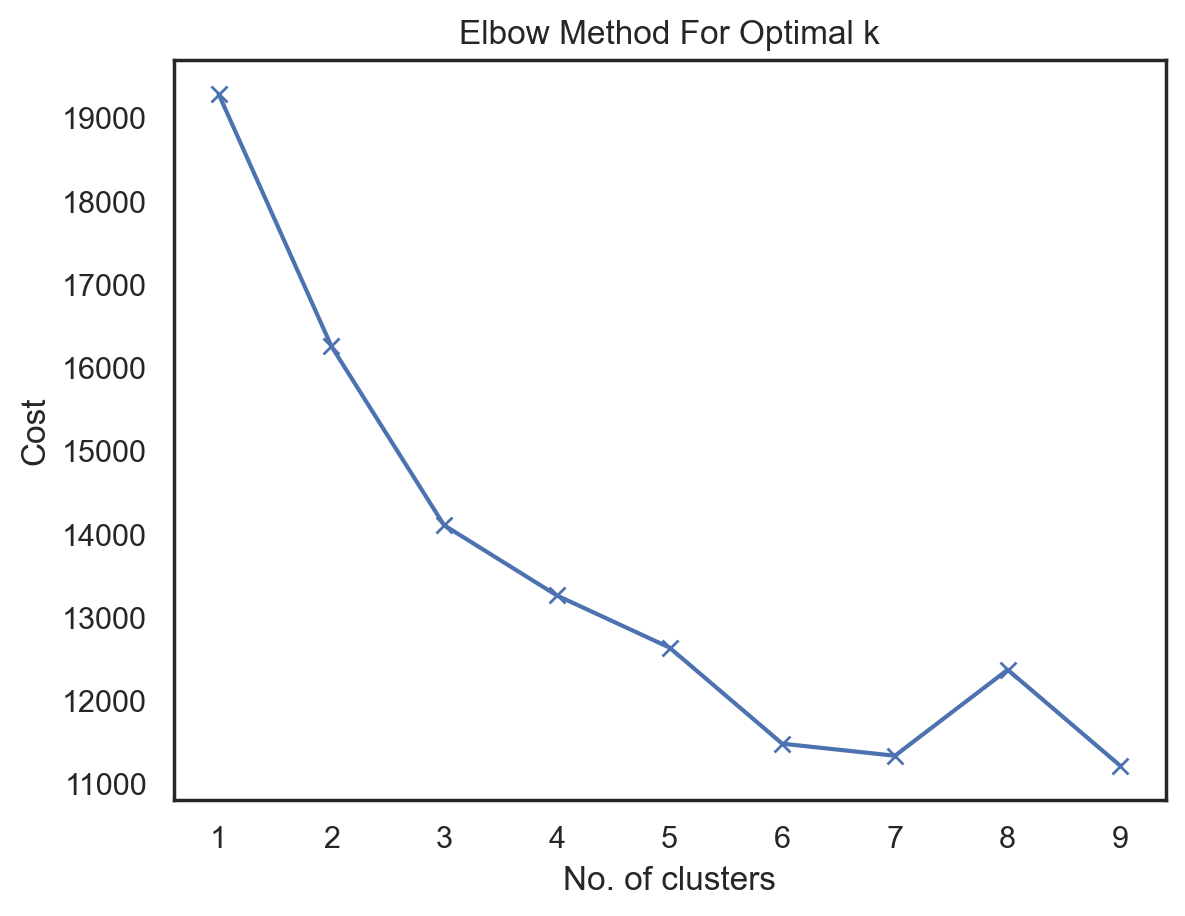

In [57]:
# Elbow curve to find optimal K
cost = []
K = range(1,10)
for num_clusters in list(K):
    kmode = KModes(n_clusters=num_clusters, init = "random", n_init = 5)
    kmode.fit_predict(df_dem)
    cost.append(kmode.cost_)
    
plt.plot(K, cost, 'bx-')
plt.xlabel('No. of clusters')
plt.ylabel('Cost')
plt.title('Elbow Method For Optimal k')
plt.show()

### Exploring 4 Clusters

In [60]:
categorical = [0,1]
kmode4 = KModes(n_clusters=4, init = "random", n_init = 5)
clusters_4 = kmode4.fit_predict(df_dem, categorical=categorical)

pd.Series(clusters_4).value_counts()

1    3594
0    3205
3    2178
2    1261
dtype: int64

In [61]:
df_dem_4_clusters=pd.DataFrame(clusters_4+1,index=df_dem.index).rename(columns={0:'demographic_clusters_4'})
df_dem_4_clusters= pd.concat((df_dem_4_clusters, df_dem), axis=1)
df_dem_4_clusters_mean = df_dem_4_clusters.groupby('demographic_clusters_4').mean()

In [62]:
def highlight_max(s):
    is_max = s == s.max()
    return ['background: red' if cell else '' for cell in is_max]
  
df_dem_4_clusters_mean.style.apply(highlight_max)

### Exploring 5 Clusters

In [181]:
kmode5 = KModes(n_clusters=5, init = "random", n_init = 5)
clusters_5_dem = kmode5.fit_predict(df_dem, categorical=categorical)

pd.Series(clusters_5).value_counts()

0    2995
3    2864
2    2191
4    2187
1       1
dtype: int64

In [182]:
df_dem_5_clusters=pd.DataFrame(clusters_5+1,index=df_dem.index).rename(columns={0:'demographic_clusters_5'})
df_dem_5_clusters= pd.concat((df_dem_5_clusters, df_dem), axis=1)
df_dem_5_clusters_mean = df_dem_5_clusters.groupby('demographic_clusters_5').mean()

In [183]:
df_dem_5_clusters_mean.drop([pd.Series(clusters_5).value_counts().index[4]]).style.apply(highlight_max)

## K-Means and Product Features

In [134]:
def get_ss(df):
    """Computes the sum of squares for all variables given a dataset
    """
    ss = np.sum(df.var() * (df.count() - 1))
    return ss  # return sum of sum of squares of each df variable

def r2(df, labels):
    sst = get_ss(df)
    ssw = np.sum(df.groupby(labels).apply(get_ss))
    return 1 - ssw/sst
    
def get_r2_scores(df, clusterer, min_k=2, max_k=10):
    """
    Loop over different values of k. To be used with sklearn clusterers.
    """
    r2_clust = {}
    for n in range(min_k, max_k):
        clust = clone(clusterer).set_params(n_clusters=n)
        labels = clust.fit_predict(df)
        r2_clust[n] = r2(df, labels)
    return r2_clust


# Set up the clusterers
kmeans = KMeans(
    init='k-means++',
    n_init=20,
    random_state=42
)

hierarchical = AgglomerativeClustering(
    affinity='euclidean'
)

In [136]:
# Obtaining the R² scores for each cluster solution on demographic variables
r2_scores = {}
r2_scores['kmeans'] = get_r2_scores(df_prf, kmeans)

for linkage in ['complete', 'average', 'single', 'ward']:
    r2_scores[linkage] = get_r2_scores(
        df_prf, hierarchical.set_params(linkage=linkage)
    )

pd.DataFrame(r2_scores).style.highlight_max(color = 'red', axis = 1)

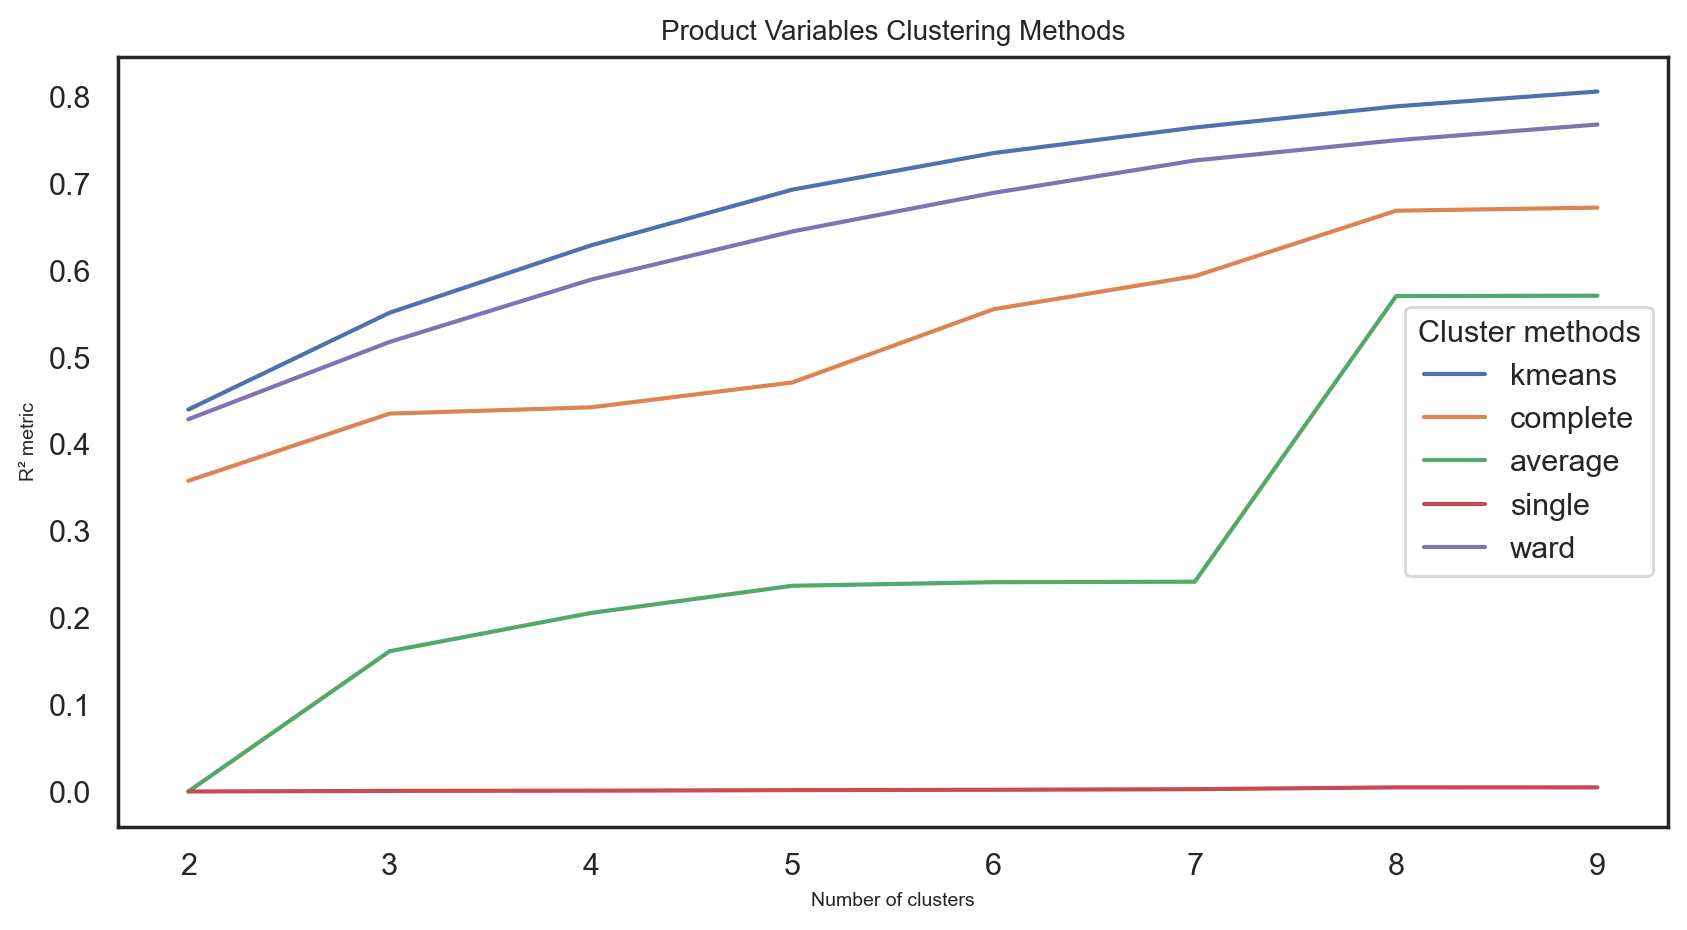

In [137]:
# Visualizing the R² scores for each cluster solution on demographic variables
pd.DataFrame(r2_scores).plot.line(figsize=(10,5))

plt.title("Product Variables Clustering Methods", fontsize=10)
plt.legend(title="Cluster methods", title_fontsize=11)
plt.xlabel("Number of clusters", fontsize=7)
plt.ylabel("R² metric", fontsize=7)
plt.show()

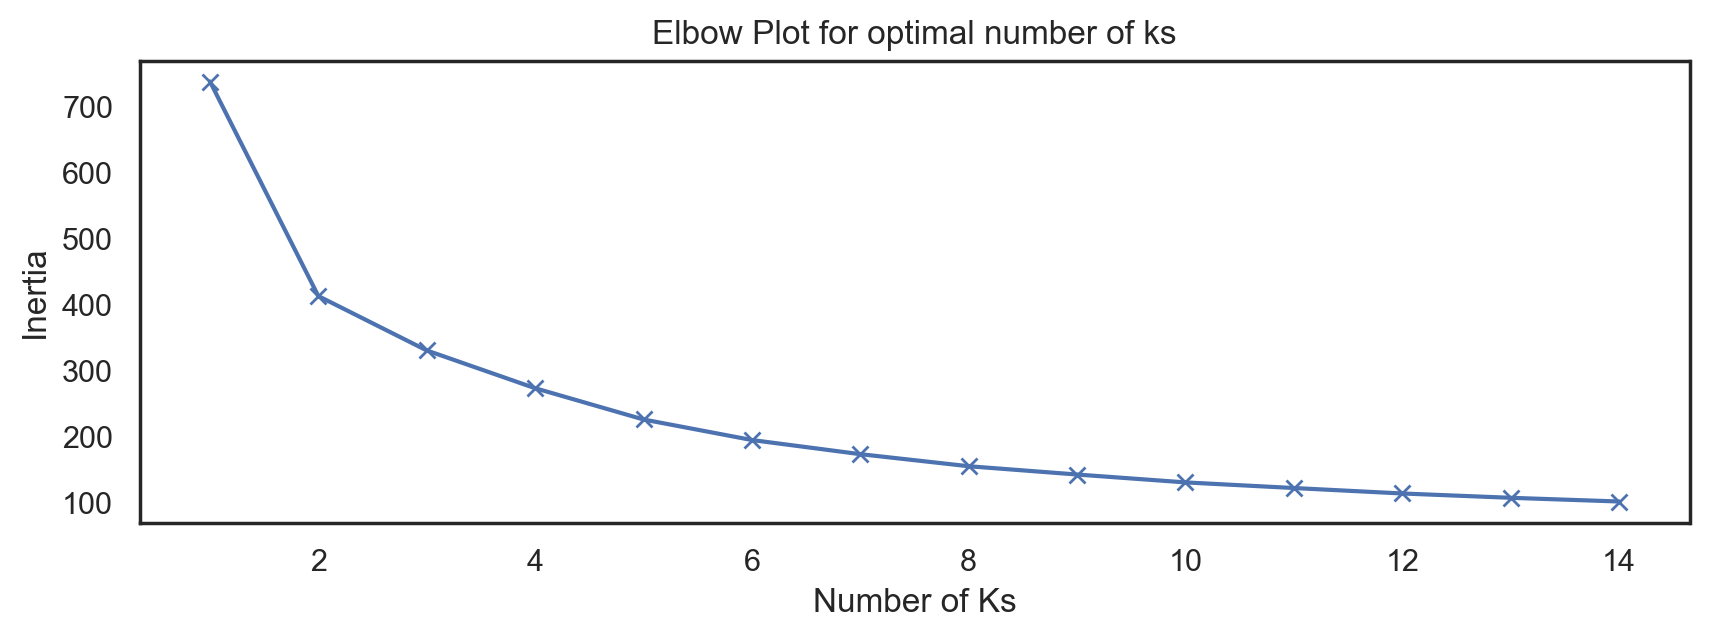

In [138]:
inertia = []
for i in range(1, 15):
    kmeans =  kmeans = KMeans(n_clusters=i).fit(df_prf)
    inertia.append(kmeans.inertia_)
plt.figure(figsize=(10,3))
plt.plot(range(1, 15), inertia, 'bx-')
plt.xlabel('Number of Ks')
plt.ylabel('Inertia')
plt.title('Elbow Plot for optimal number of ks')
plt.show()

### Exploring 2 Clusters

In [157]:
kmeans2 = KMeans(n_clusters=2).fit(df_prf)
clusters_2 = kmeans2.fit_predict(df_prf)

pd.Series(clusters_2).value_counts()

1    5233
0    5005
dtype: int64

In [158]:
df_prf_2_clusters=pd.DataFrame(clusters_2+1,index=df_prf.index).rename(columns={0:'product_clusters_2'})
df_prf_2_clusters= pd.concat((df_prf_2_clusters, df_prf), axis=1)
df_prf_2_clusters_mean = df_prf_2_clusters.groupby('product_clusters_2').mean()

In [159]:
def highlight_max(s):
    is_max = s == s.max()
    return ['background: red' if cell else '' for cell in is_max]
  
df_prf_2_clusters_mean.style.apply(highlight_max)

### Exploring 3 Clusters

In [177]:
kmeans3 = KMeans(n_clusters=3).fit(df_prf)
clusters_3_prod = kmeans3.fit_predict(df_prf)

pd.Series(clusters_3).value_counts()

2    4154
0    4048
1    2036
dtype: int64

In [178]:
df_prf_3_clusters=pd.DataFrame(clusters_3+1,index=df_prf.index).rename(columns={0:'product_clusters_3'})
df_prf_3_clusters= pd.concat((df_prf_3_clusters, df_prf), axis=1)
df_prf_3_clusters_mean = df_prf_3_clusters.groupby('product_clusters_3').mean()

In [179]:
def highlight_max(s):
    is_max = s == s.max()
    return ['background: red' if cell else '' for cell in is_max]
  
df_prf_3_clusters_mean.style.apply(highlight_max)

### Exploring 4 Clusters

In [151]:
kmeans4 = KMeans(n_clusters=4).fit(df_prf)
clusters_4 = kmeans4.fit_predict(df_prf)

pd.Series(clusters_4).value_counts()

0    3520
1    3243
2    2202
3    1273
dtype: int64

In [152]:
df_prf_4_clusters=pd.DataFrame(clusters_4+1,index=df_prf.index).rename(columns={0:'product_clusters_4'})
df_prf_4_clusters= pd.concat((df_prf_4_clusters, df_prf), axis=1)
df_prf_4_clusters_mean = df_prf_4_clusters.groupby('product_clusters_4').mean()

In [153]:
def highlight_max(s):
    is_max = s == s.max()
    return ['background: red' if cell else '' for cell in is_max]
  
df_prf_4_clusters_mean.style.apply(highlight_max)

## Merging Product & Demographic Clusters

From both Product and Demographic Cluster Exploration we select:

1. K=3 Clusters for Product
2. K=5 Clusters for Demographic

In [318]:
prod_labels = clusters_3_prod

behavior_labels = clusters_5_dem

df['product_labels'] = prod_labels
df['behavior_labels'] = behavior_labels

In [319]:
# Count label frequencies (contigency table)
df.groupby(['product_labels', 'behavior_labels'])\
    .size()\
    .to_frame()\
    .reset_index()\
    .pivot('behavior_labels', 'product_labels', 0)

product_labels      0     1     2
behavior_labels                  
0                1083  1071  2189
1                 428   192   413
2                1058   176   189
3                 492   544  1142
4                 968   155   138

### Manual merging: Merge lowest frequency clusters into closest clusters

In [308]:
# Clusters with low frequency to be merged:
to_merge = [(4,1), (4,2), (2,1), (2,2), (1,1)]

df_centroids = df.groupby(['behavior_labels', 'product_labels'])\
    [metric_features].mean()

# Computing the euclidean distance matrix between the centroids
euclidean = pairwise_distances(df_centroids)
df_dists = pd.DataFrame(
    euclidean, columns=df_centroids.index, index=df_centroids.index
)

# Merging each low frequency clustering (source) to the closest cluster (target)
source_target = {}
for clus in to_merge:
    if clus not in source_target.values():
        source_target[clus] = df_dists.loc[clus].sort_values().index[1]

source_target

{(4, 1): (2, 1), (4, 2): (2, 2), (1, 1): (0, 1)}

In [309]:
df_ = df.copy()

# Changing the behavior_labels and product_labels based on source_target
for source, target in source_target.items():
    mask = (df_['behavior_labels']==source[0]) & (df_['product_labels']==source[1])
    df_.loc[mask, 'behavior_labels'] = target[0]
    df_.loc[mask, 'product_labels'] = target[1]

# New contigency table
df_.groupby(['product_labels', 'behavior_labels'])\
    .size()\
    .to_frame()\
    .reset_index()\
    .pivot('behavior_labels', 'product_labels', 0)

product_labels        0       1       2
behavior_labels                        
0                1083.0  1263.0  2189.0
1                 428.0     NaN   413.0
2                1058.0   331.0   327.0
3                 492.0   544.0  1142.0
4                 968.0     NaN     NaN

In [280]:
df_ = df_.copy()

# Changing the behavior_labels and product_labels based on source_target
for source, target in source_target.items():
    mask = (df_['behavior_labels']==source[0]) & (df_['product_labels']==source[1])
    df_.loc[mask, 'behavior_labels'] = target[0]
    df_.loc[mask, 'product_labels'] = target[1]

# New contigency table
df_.groupby(['product_labels', 'behavior_labels'])\
    .size()\
    .to_frame()\
    .reset_index()\
    .pivot('behavior_labels', 'product_labels', 0)

product_labels        0       1       2
behavior_labels                        
0                1083.0  1263.0  2189.0
1                 428.0     NaN   413.0
2                1058.0   331.0   327.0
3                 492.0   544.0  1142.0
4                 968.0     NaN     NaN

### Merging using Hierarchical clustering

In [452]:
# Centroids of the concatenated cluster labels
df_centroids = df.groupby(['behavior_labels', 'product_labels'])\
    [metric_features].mean()
df_centroids

FirstPolYear  MonthSal  CustMonVal  \
behavior_labels product_labels                                       
0               0                   0.503770  0.625731    0.376731   
                1                   0.497238  0.194830    0.416192   
                2                   0.496726  0.388289    0.333465   
1               0                   0.498929  0.683585    0.365994   
                1                   0.516927  0.192811    0.420486   
                2                   0.513620  0.393359    0.327047   
2               0                   0.520951  0.718275    0.360347   
                1                   0.468513  0.174697    0.427819   
                2                   0.458995  0.419557    0.331199   
3               0                   0.499915  0.627673    0.378169   
                1                   0.488511  0.193532    0.421405   
                2                   0.497884  0.393453    0.330123   
4               0                   0.508178  0.713062    0.353615   
                1                   0.480914  0.176784    0.433786   
                2                   0.481582  0.419372    0.319527   

                                ClaimsRate  PremMotor  PremHousehold  \
behavior_labels product_labels                                         
0               0                 0.386951   0.615751       0.151421   
                1                 0.382001   0.318672       0.304855   
                2                 0.442025   0.625719       0.106886   
1               0                 0.414979   0.508871       0.169407   
                1                 0.378247   0.297538       0.328466   
                2                 0.453442   0.623116       0.107665   
2               0                 0.428598   0.432322       0.183091   
                1                 0.401866   0.206658       0.373370   
                2                 0.447319   0.548530       0.136401   
3               0                 0.379165   0.619526       0.145603   
                1                 0.377281   0.311748       0.311768   
                2                 0.449958   0.622067       0.107186   
4               0                 0.438457   0.438885       0.179843   
                1                 0.388451   0.224707       0.377373   
                2                 0.477143   0.533698       0.144049   

                                PremHealth  PremLife  PremWork  \
behavior_labels product_labels                                   
0               0                 0.309045  0.120707  0.118968   
                1                 0.423751  0.252378  0.220416   
                2                 0.338203  0.107791  0.104788   
1               0                 0.401501  0.152644  0.134323   
                1                 0.414578  0.252721  0.242371   
                2                 0.339761  0.101007  0.103137   
2               0                 0.479254  0.157789  0.142559   
                1                 0.403696  0.337268  0.298751   
                2                 0.335770  0.152523  0.143207   
3               0                 0.303889  0.122852  0.117415   
                1                 0.428729  0.241130  0.225827   
                2                 0.339392  0.112824  0.105558   
4               0                 0.475869  0.161063  0.140829   
                1                 0.364219  0.363214  0.275873   
                2                 0.368328  0.164554  0.143971   

                                Cust_Retention  Prem_Total  Year_Sal  \
behavior_labels product_labels                                         
0               0                     0.496230    0.399616  0.625731   
                1                     0.502762    0.508806  0.194830   
                2                     0.503274    0.365803  0.388289   
1               0                     0.501071    0.411869  0.683585   
                1                     0.483073    0.524922  0

In [453]:
# Using Hierarchical clustering to merge the concatenated cluster centroids
hclust = AgglomerativeClustering(
    linkage='ward', 
    affinity='euclidean', 
    distance_threshold=0, 
    n_clusters=None
)
hclust_labels = hclust.fit_predict(df_centroids)

NameError: name 'distance' is not defined

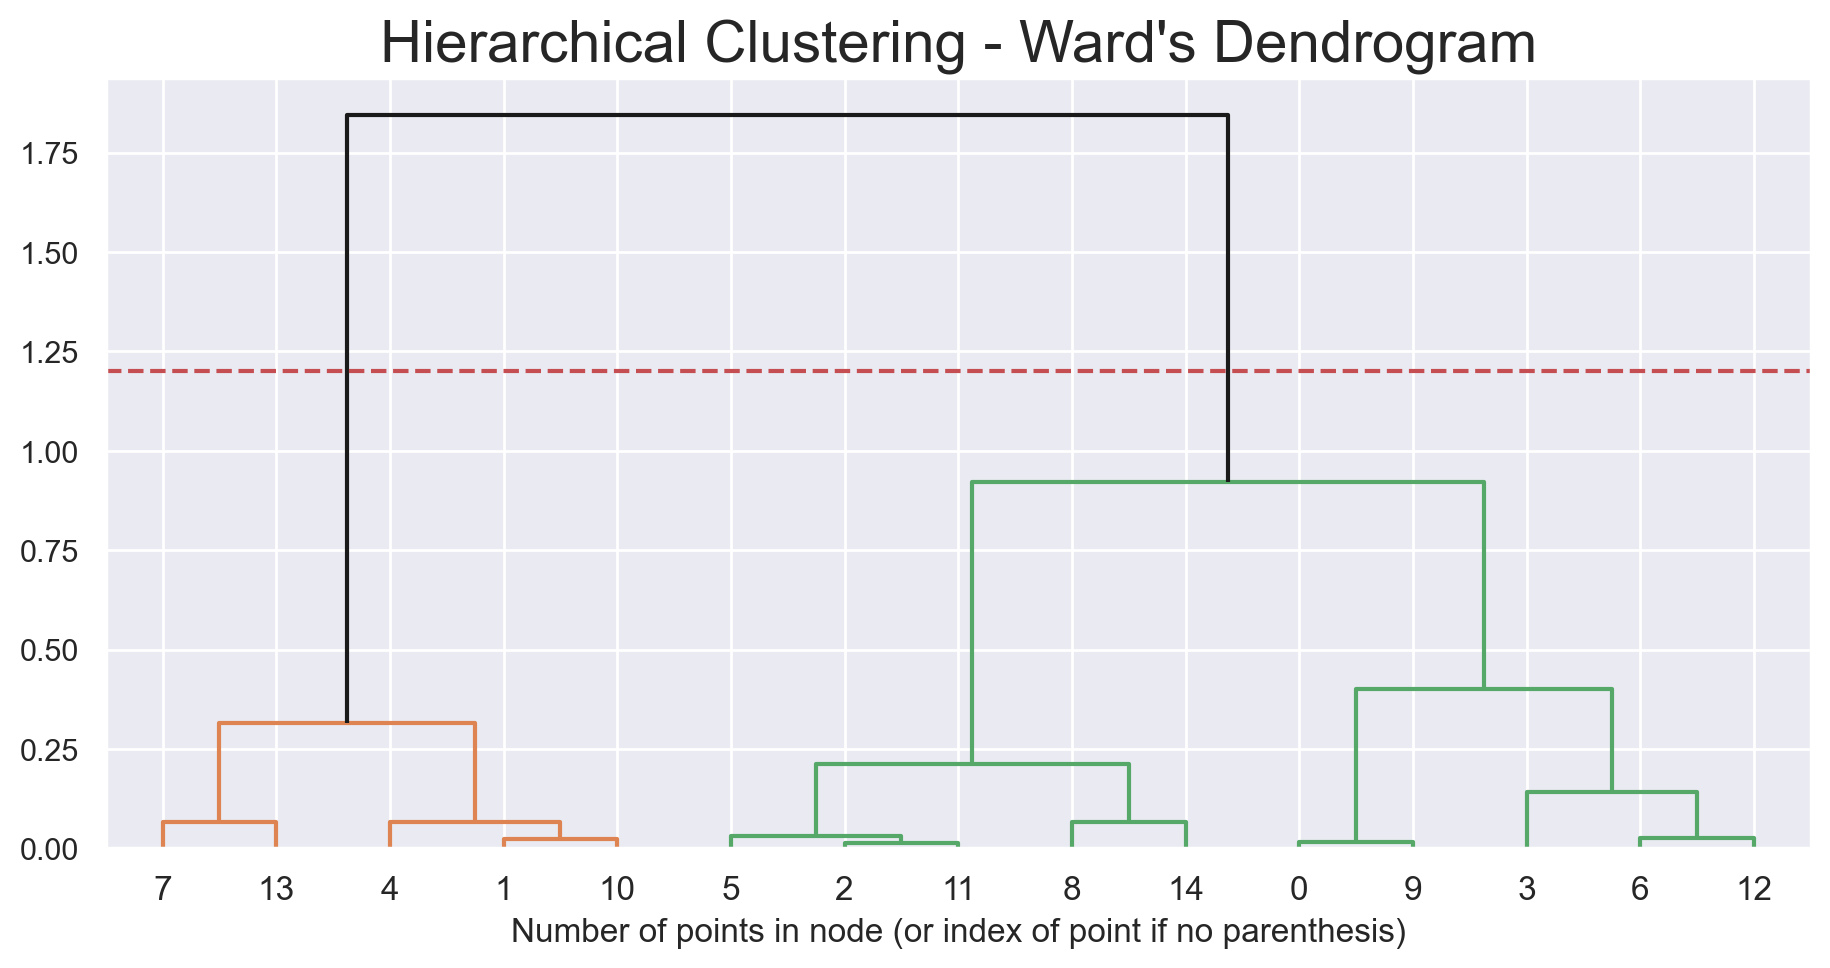

In [454]:
# create the counts of samples under each node (number of points being merged)
counts = np.zeros(hclust.children_.shape[0])
n_samples = len(hclust.labels_)

# hclust.children_ contains the observation ids that are being merged together
# At the i-th iteration, children[i][0] and children[i][1] are merged to form node n_samples + i
for i, merge in enumerate(hclust.children_):
    # track the number of observations in the current cluster being formed
    current_count = 0
    for child_idx in merge:
        if child_idx < n_samples:
            # If this is True, then we are merging an observation
            current_count += 1  # leaf node
        else:
            # Otherwise, we are merging a previously formed cluster
            current_count += counts[child_idx - n_samples]
    counts[i] = current_count

# the hclust.children_ is used to indicate the two points/clusters being merged (dendrogram's u-joins)
# the hclust.distances_ indicates the distance between the two points/clusters (height of the u-joins)
# the counts indicate the number of points being merged (dendrogram's x-axis)
linkage_matrix = np.column_stack(
    [hclust.children_, hclust.distances_, counts]
).astype(float)

# Plot the corresponding dendrogram
fig = plt.figure(figsize=(11,5))
# The Dendrogram parameters need to be tuned
y_threshold = 1.2
dendrogram(linkage_matrix, truncate_mode='level', p=5, color_threshold=y_threshold, above_threshold_color='k')
plt.hlines(y_threshold, 0, 1000, colors="r", linestyles="dashed")
plt.title(f'Hierarchical Clustering - {linkage.title()}\'s Dendrogram', fontsize=21)
plt.xlabel('Number of points in node (or index of point if no parenthesis)')
plt.ylabel(f'{distance.title()} Distance', fontsize=13)
#plt.savefig(os.path.join('..\DataMining_project_master.git/figures', 'dendogram_hierarquical'), dpi=200)
plt.show()

In [455]:
# Re-running the Hierarchical clustering based on the correct number of clusters
hclust = AgglomerativeClustering(
    linkage='ward', 
    affinity='euclidean', 
    n_clusters=6
)
hclust_labels = hclust.fit_predict(df_centroids)
df_centroids['hclust_labels'] = hclust_labels

df_centroids # centroid's cluster labels

FirstPolYear  MonthSal  CustMonVal  \
behavior_labels product_labels                                       
0               0                   0.503770  0.625731    0.376731   
                1                   0.497238  0.194830    0.416192   
                2                   0.496726  0.388289    0.333465   
1               0                   0.498929  0.683585    0.365994   
                1                   0.516927  0.192811    0.420486   
                2                   0.513620  0.393359    0.327047   
2               0                   0.520951  0.718275    0.360347   
                1                   0.468513  0.174697    0.427819   
                2                   0.458995  0.419557    0.331199   
3               0                   0.499915  0.627673    0.378169   
                1                   0.488511  0.193532    0.421405   
                2                   0.497884  0.393453    0.330123   
4               0                   0.508178  0.713062    0.353615   
                1                   0.480914  0.176784    0.433786   
                2                   0.481582  0.419372    0.319527   

                                ClaimsRate  PremMotor  PremHousehold  \
behavior_labels product_labels                                         
0               0                 0.386951   0.615751       0.151421   
                1                 0.382001   0.318672       0.304855   
                2                 0.442025   0.625719       0.106886   
1               0                 0.414979   0.508871       0.169407   
                1                 0.378247   0.297538       0.328466   
                2                 0.453442   0.623116       0.107665   
2               0                 0.428598   0.432322       0.183091   
                1                 0.401866   0.206658       0.373370   
                2                 0.447319   0.548530       0.136401   
3               0                 0.379165   0.619526       0.145603   
                1                 0.377281   0.311748       0.311768   
                2                 0.449958   0.622067       0.107186   
4               0                 0.438457   0.438885       0.179843   
                1                 0.388451   0.224707       0.377373   
                2                 0.477143   0.533698       0.144049   

                                PremHealth  PremLife  PremWork  \
behavior_labels product_labels                                   
0               0                 0.309045  0.120707  0.118968   
                1                 0.423751  0.252378  0.220416   
                2                 0.338203  0.107791  0.104788   
1               0                 0.401501  0.152644  0.134323   
                1                 0.414578  0.252721  0.242371   
                2                 0.339761  0.101007  0.103137   
2               0                 0.479254  0.157789  0.142559   
                1                 0.403696  0.337268  0.298751   
                2                 0.335770  0.152523  0.143207   
3               0                 0.303889  0.122852  0.117415   
                1                 0.428729  0.241130  0.225827   
                2                 0.339392  0.112824  0.105558   
4               0                 0.475869  0.161063  0.140829   
                1                 0.364219  0.363214  0.275873   
                2                 0.368328  0.164554  0.143971   

                                Cust_Retention  Prem_Total  Year_Sal  \
behavior_labels product_labels                                         
0               0                     0.496230    0.399616  0.625731   
                1                     0.502762    0.508806  0.194830   
                2                     0.503274    0.365803  0.388289   
1               0                     0.501071    0.411869  0.683585   
                1                     0.483073    0.524922  0

In [456]:
# Mapper between concatenated clusters and hierarchical clusters
cluster_mapper = df_centroids['hclust_labels'].to_dict()

df_ = df.copy()

# Mapping the hierarchical clusters on the centroids to the observations
df_['merged_labels'] = df_.apply(
    lambda row: cluster_mapper[
        (row['behavior_labels'], row['product_labels'])
    ], axis=1
)

# Merged cluster centroids
df_.groupby('merged_labels').mean()[metric_features]

FirstPolYear  MonthSal  CustMonVal  ClaimsRate  PremMotor  \
merged_labels                                                              
0                  0.512072  0.710168    0.358677    0.430112   0.448261   
1                  0.468527  0.419479    0.326273    0.459905   0.542271   
2                  0.496703  0.194225    0.418218    0.380181   0.314342   
3                  0.502566  0.626337    0.377180    0.384519   0.616930   
4                  0.474320  0.175674    0.430613    0.395584   0.215110   
5                  0.498943  0.390424    0.331738    0.445704   0.624318   

               PremHousehold  PremHealth  PremLife  PremWork  Cust_Retention  \
merged_labels                                                                  
0                   0.179423    0.464358  0.158183  0.140440        0.487928   
1                   0.139629    0.349510  0.157600  0.143529        0.531473   
2                   0.309445    0.424275  0.249028  0.224378        0.503297   
3                   0.149604    0.307435  0.121377  0.118483        0.497434   
4                   0.375245    0.385210  0.349418  0.288037        0.525680   
5                   0.107064    0.338737  0.108578  0.104841        0.501057   

               Prem_Total  Year_Sal  Commitment  Motor_Commitment  \
merged_labels                                                       
0                0.418568  0.710168    0.047765          0.098656   
1                0.386455  0.419479    0.072271          0.179186   
2                0.511793  0.194225    0.195289          0.195431   
3                0.398020  0.626337    0.050731          0.145601   
4                0.557595  0.175674    0.231653          0.146379   
5                0.365778  0.390424    0.072653          0.217498   

               Houehold_Commitment  Healthr_Commitment  Life_Commitment  \
merged_labels                                                             
0                         0.053613            0.062210         0.026728   
1                         0.055809            0.079084         0.038535   
2                         0.150121            0.186709         0.105528   
3                         0.051349            0.046254         0.023779   
4                         0.188355            0.187307         0.153526   
5                         0.050090            0.082162         0.029330   

               Work_Commitment  Yearly_Cost  
merged_labels                                
0                     0.041328     0.268318  
1                     0.054968     0.270970  
2                     0.131860     0.295206  
3                     0.039435     0.230792  
4                     0.179556     0.325410  
5                     0.045480     0.246358

In [457]:
#Merge cluster contigency table
# Getting size of each final cluster
df_counts = df_.groupby('merged_labels')\
    .size()\
    .to_frame()

# Getting the product and behavior labels
df_counts = df_counts\
    .rename({v:k for k, v in cluster_mapper.items()})\
    .reset_index()

df_counts['behavior_labels'] = df_counts['merged_labels'].apply(lambda x: x[0])
df_counts['product_labels'] = df_counts['merged_labels'].apply(lambda x: x[1])
df_counts.pivot('behavior_labels', 'product_labels', 0)

product_labels      0     1     2
behavior_labels                  
3                1575  1807  3744
4                2454   331   327

In [458]:
# Clusters with low frequency to be merged:
to_merge = [(4,1), (4,2)]

df_centroids = df.groupby(['behavior_labels', 'product_labels'])\
    [metric_features].mean()

# Computing the euclidean distance matrix between the centroids
euclidean = pairwise_distances(df_centroids[9:])
df_dists = pd.DataFrame(
    euclidean, columns=targets_list, index=targets_list
)
df_dists

(3, 0)    (3, 1)        (3, 2)    (4, 0)    (4, 1)        (4, 2)
(3, 0)  0.000000  0.793817  3.578315e-01  0.299918  0.921726  3.481953e-01
(3, 1)  0.793817  0.000000  5.865015e-01  0.823704  0.218533  5.248693e-01
(3, 2)  0.357832  0.586501  2.107342e-08  0.533874  0.752736  1.437051e-01
(4, 0)  0.299918  0.823704  5.338739e-01  0.000000  0.931638  4.551390e-01
(4, 1)  0.921726  0.218533  7.527362e-01  0.931638  0.000000  6.748868e-01
(4, 2)  0.348195  0.524869  1.437051e-01  0.455139  0.674887  2.980232e-08

In [459]:
source_target={(4, 1):(4, 0),  (4,2): (3, 0)}

In [460]:
df_['merged_labels'].value_counts()

5    3744
0    2454
2    1807
3    1575
4     331
1     327
Name: merged_labels, dtype: int64

In [479]:
#df_[(df_['product_labels']==1) & (df_['behavior_labels']==4)]['merged_labels']
df_[df_['merged_labels']==4] = 0

df_[df_['merged_labels']==1] = 3
#df_[(df_['product_labels']==2) & (df_['behavior_labels']==4)]['merged_labels']==3

In [480]:
df_['merged_labels'].value_counts()

5    3744
0    2785
3    1902
2    1807
Name: merged_labels, dtype: int64

In [481]:
#Merge cluster contigency table
# Getting size of each final cluster
df_counts = df_.groupby('merged_labels')\
    .size()\
    .to_frame()

# Getting the product and behavior labels
df_counts = df_counts\
    .rename({v:k for k, v in cluster_mapper.items()})\
    .reset_index()

df_counts['behavior_labels'] = df_counts['merged_labels'].apply(lambda x: x[0])
df_counts['product_labels'] = df_counts['merged_labels'].apply(lambda x: x[1])
df_counts.pivot('behavior_labels', 'product_labels', 0)

product_labels        0       1       2
behavior_labels                        
3                1902.0  1807.0  3744.0
4                2785.0     NaN     NaN

In [482]:
df_

FirstPolYear  EducDeg  MonthSal  GeoLivArea  Children  CustMonVal  \
CustID                                                                       
1.0          0.458333      2.0  0.393345         1.0       1.0    0.447640   
2.0          0.291667      2.0  0.073379         4.0       1.0    0.184504   
3.0          3.000000      3.0  3.000000         3.0       3.0    3.000000   
4.0          0.666667      3.0  0.163396         4.0       1.0    0.243153   
5.0          0.500000      3.0  0.305034         4.0       1.0    0.269986   
...               ...      ...       ...         ...       ...         ...   
10292.0      0.416667      4.0  0.609002         2.0       0.0    0.251827   
10293.0      0.000000      0.0  0.000000         0.0       0.0    0.000000   
10294.0      0.833333      3.0  0.551408         1.0       1.0    0.521186   
10295.0      0.291667      1.0  0.349403         2.0       1.0    0.380368   
10296.0      0.666667      4.0  0.529437         1.0       1.0    0.490175   

         ClaimsRate  PremMotor  PremHousehold  PremHealth  ...  Commitment  \
CustID                                                     ...               
1.0        0.240741   0.644732       0.097258    0.333663  ...    0.069788   
2.0        0.691358   0.138411       0.309310    0.266984  ...    0.307159   
3.0        3.000000   3.000000       3.000000    3.000000  ...    3.000000   
4.0        0.611111   0.316614       0.074525    0.704047  ...    0.124767   
5.0        0.555556   0.581559       0.077328    0.415084  ...    0.081474   
...             ...        ...            ...         ...  ...         ...   
10292.0    0.592593   0.675089       0.078367    0.395352  ...    0.045938   
10293.0    0.000000   0.000000       0.000000    0.000000  ...    0.000000   
10294.0    0.129630   0.691870       0.130852    0.324426  ...    0.054466   
10295.0    0.401235   0.326981       0.180190    0.450547  ...    0.089748   
10296.0    0.166667   0.709602       0.106703    0.322179  ...    0.054296   

         Motor_Commitment  Houehold_Commitment  Healthr_Commitment  \
CustID                                                               
1.0              0.219623             0.047332            0.074396   
2.0              0.149279             0.213990            0.189395   
3.0              3.000000             3.000000            3.000000   
4.0              0.211645             0.048182            0.310567   
5.0              0.243089             0.044628            0.114144   
...                   ...                  ...                 ...   
10292.0          0.160261             0.041284            0.060493   
10293.0          0.000000             0.000000            0.000000   
10294.0          0.178161             0.049930            0.054181   
10295.0          0.126647             0.067688            0.110946   
10296.0          0.188759             0.046484            0.055743   

         Life_Commitment  Work_Commitment  Yearly_Cost  product_labels  \
CustID                                                                   
1.0             0.040353         0.036591     0.133323               2   
2.0             0.398995         0.264840     0.524046               1   
3.0             3.000000         3.000000     3.000000               3   
4.0             0.054612         0.064207     0.305443               2   
5.0             0.025583         0.060721     0.290878               2   
...                  ...              ...          ...             ...   
10292.0         0.015344         0.031808     0.316345               0   
10293.0         0.000000         0.000000     0.000000               0   
10294.0         0.017064         0.027274     0.075098               0   
10295.0         0.054968         0.112457     0.258716               2   
10296.0         0.014507         0.031721     0.092855               0   

         behavior_labels  merged_labels  
CustID                                   
1.0                  

## Cluster Analysis

In [228]:
def cluster_profiles(df, label_columns, figsize, compar_titles=None):
    """
    Pass df with labels columns of one or multiple clustering labels. 
    Then specify this label columns to perform the cluster profile according to them.
    """
    if compar_titles == None:
        compar_titles = [""]*len(label_columns)
        
    sns.set()
    fig, axes = plt.subplots(nrows=len(label_columns), ncols=2, figsize=figsize, squeeze=False)
    for ax, label, titl in zip(axes, label_columns, compar_titles):
        # Filtering df
        drop_cols = [i for i in label_columns if i!=label]
        dfax = df.drop(drop_cols, axis=1)
        
        # Getting the cluster centroids and counts
        centroids = dfax.groupby(by=label, as_index=False).mean()
        counts = dfax.groupby(by=label, as_index=False).count().iloc[:,[0,1]]
        counts.columns = [label, "counts"]
        
        # Setting Data
        pd.plotting.parallel_coordinates(centroids, label, color=sns.color_palette(), ax=ax[0])
        sns.barplot(x=label, y="counts", data=counts, ax=ax[1])

        #Setting Layout
        handles, _ = ax[0].get_legend_handles_labels()
        cluster_labels = ["Cluster {}".format(i) for i in range(len(handles))]
        ax[0].annotate(text=titl, xy=(0.95,1.1), xycoords='axes fraction', fontsize=13, fontweight = 'heavy') 
        ax[0].legend(handles, cluster_labels) # Adaptable to number of clusters
        ax[0].axhline(color="black", linestyle="--")
        ax[0].set_title("Cluster Means - {} Clusters".format(len(handles)), fontsize=13)
        ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=-20)
        ax[1].set_xticklabels(cluster_labels)
        ax[1].set_xlabel("")
        ax[1].set_ylabel("Absolute Frequency")
        ax[1].set_title("Cluster Sizes - {} Clusters".format(len(handles)), fontsize=13)
    
    plt.subplots_adjust(hspace=0.4, top=0.90)
    plt.suptitle("Cluster Simple Profilling", fontsize=23)
    plt.show()

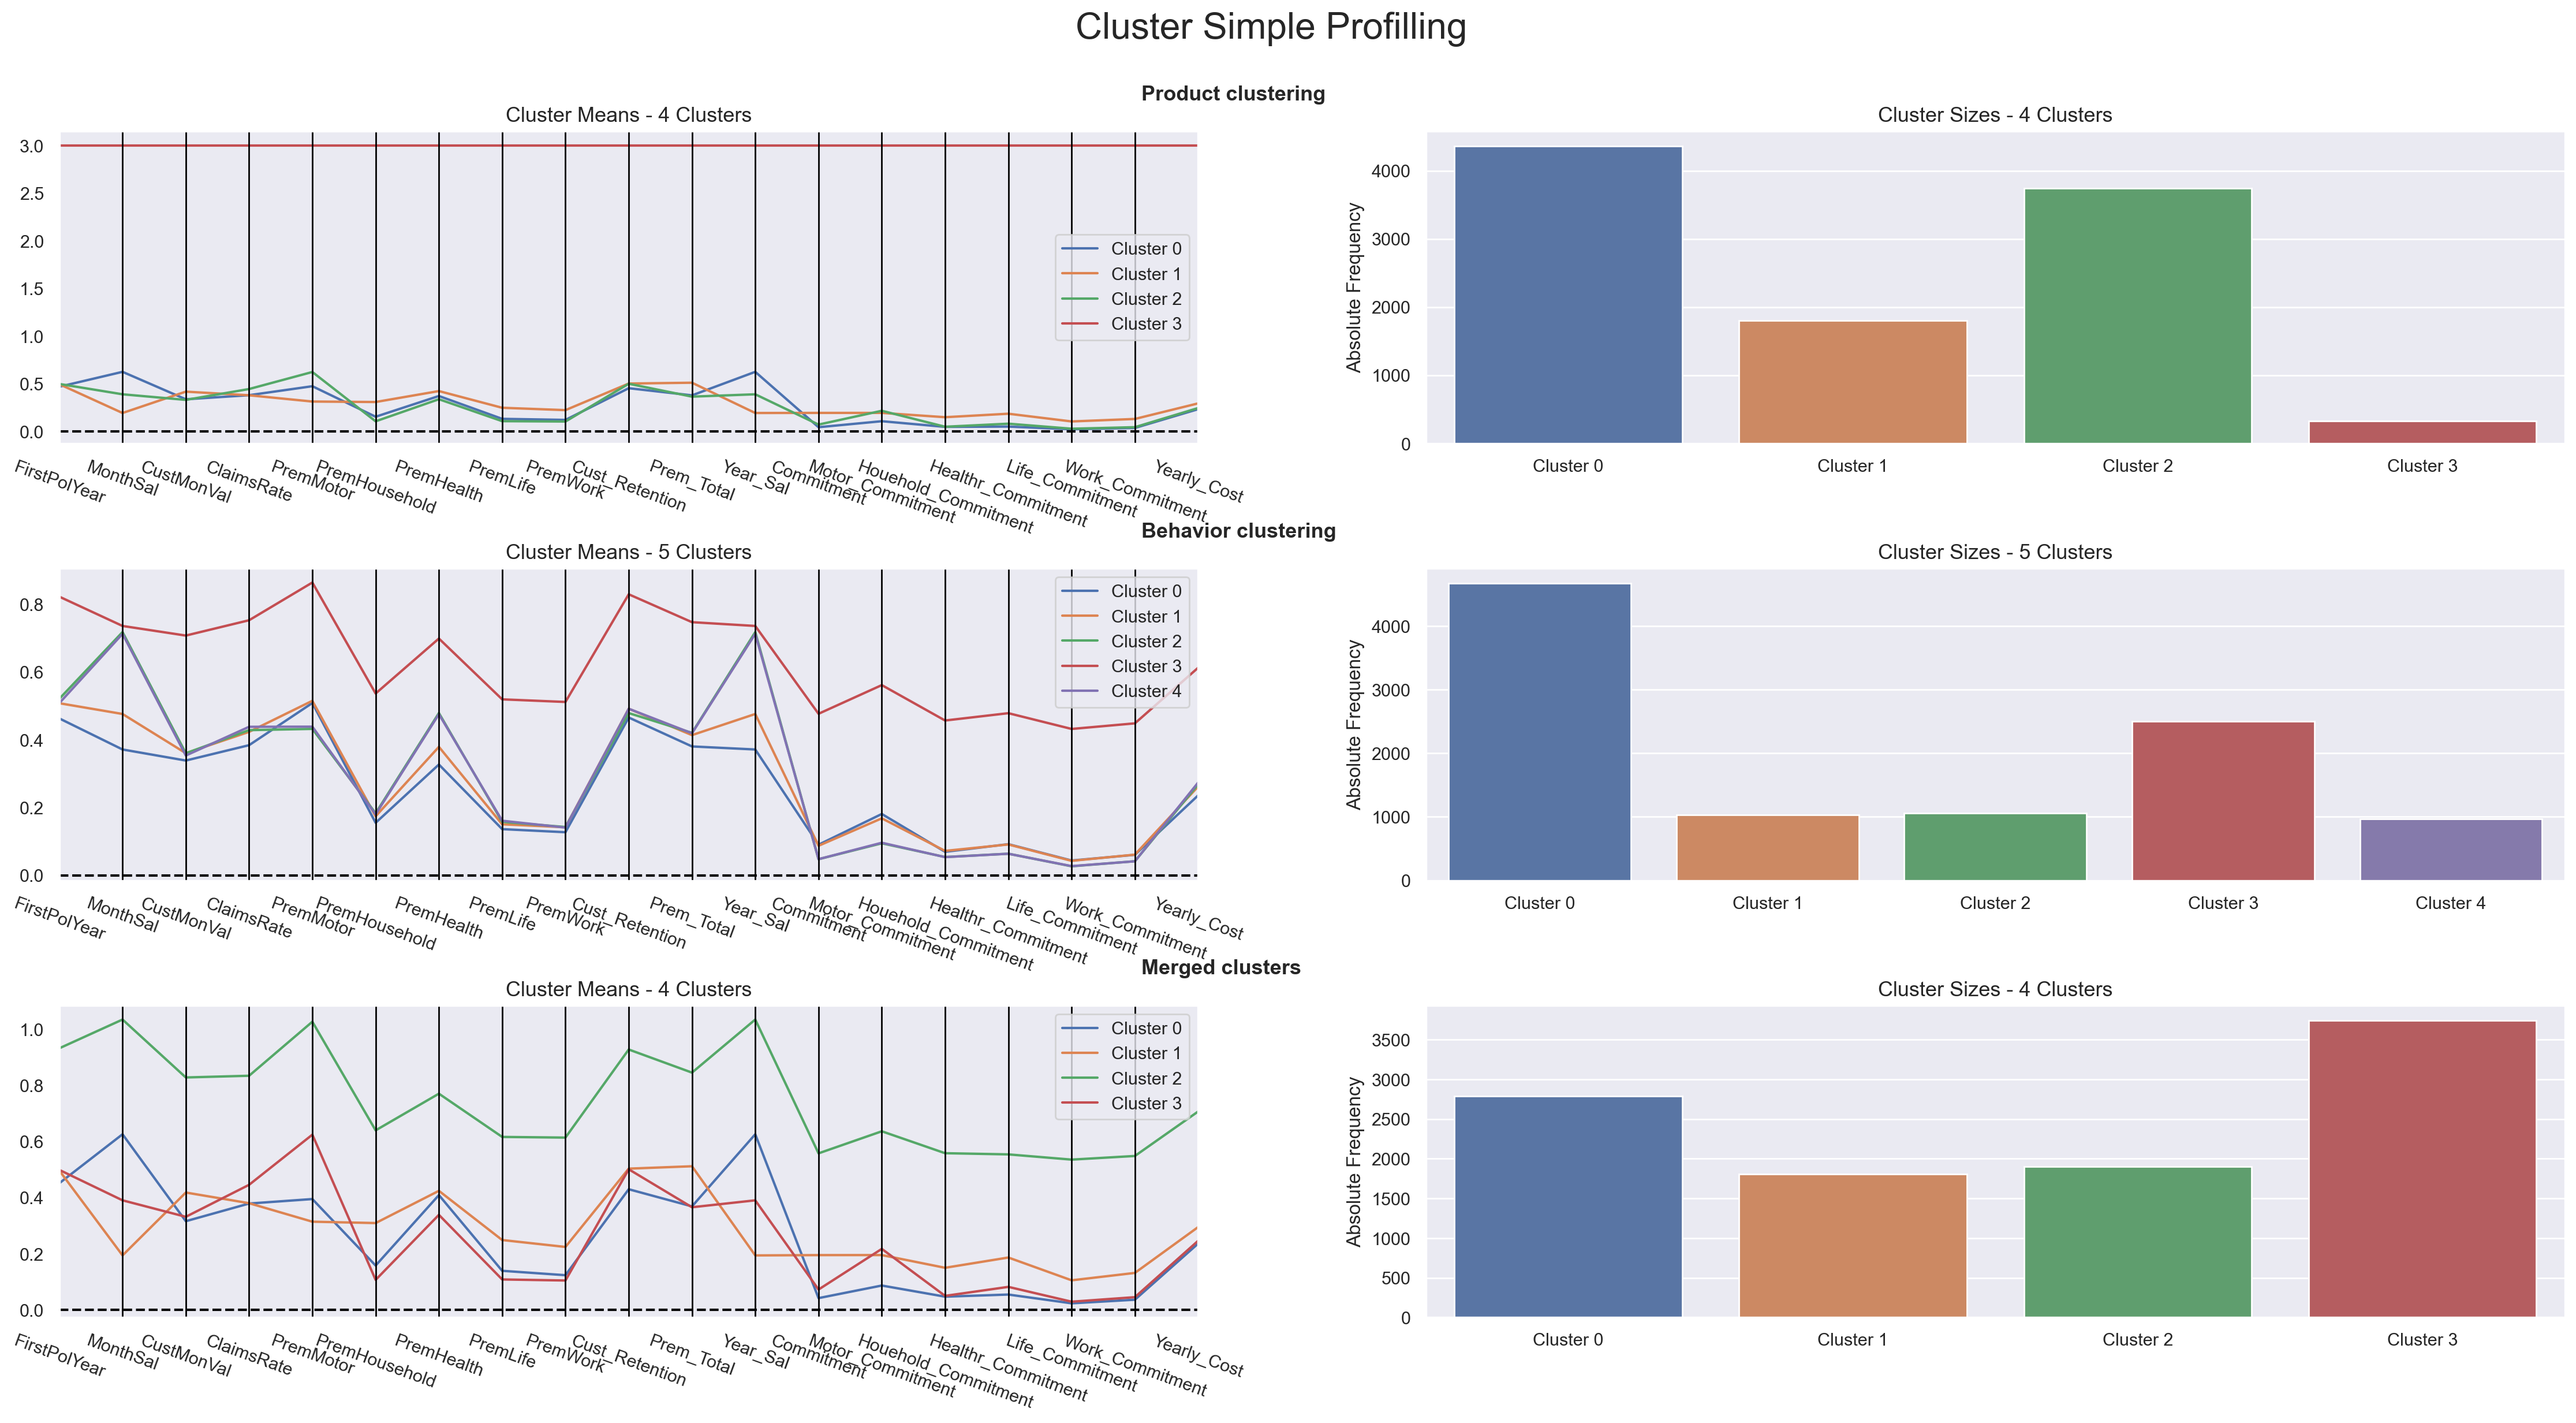

In [483]:
# Profilling each cluster (product, behavior, merged)
cluster_profiles(
    df = df_[metric_features + ['product_labels', 'behavior_labels', 'merged_labels']], 
    label_columns = ['product_labels', 'behavior_labels', 'merged_labels'], 
    figsize = (28, 13), 
    compar_titles = ["Product clustering", "Behavior clustering", "Merged clusters"]
)

## Product Cluster visualization using t-SNE

In [499]:
df

FirstPolYear  EducDeg  MonthSal  GeoLivArea  Children  CustMonVal  \
CustID                                                                       
1.0          0.458333      2.0  0.393345         1.0       1.0    0.447640   
2.0          0.291667      2.0  0.073379         4.0       1.0    0.184504   
3.0          0.708333      1.0  0.414676         3.0       0.0    0.511202   
4.0          0.666667      3.0  0.163396         4.0       1.0    0.243153   
5.0          0.500000      3.0  0.305034         4.0       1.0    0.269986   
...               ...      ...       ...         ...       ...         ...   
10292.0      0.416667      4.0  0.609002         2.0       0.0    0.251827   
10293.0      0.125000      1.0  0.447526         3.0       0.0    0.974133   
10294.0      0.833333      3.0  0.551408         1.0       1.0    0.521186   
10295.0      0.291667      1.0  0.349403         2.0       1.0    0.380368   
10296.0      0.666667      4.0  0.529437         1.0       1.0    0.490175   

         ClaimsRate  PremMotor  PremHousehold  PremHealth  ...  Year_Sal  \
CustID                                                     ...             
1.0        0.240741   0.644732       0.097258    0.333663  ...  0.393345   
2.0        0.691358   0.138411       0.309310    0.266984  ...  0.073379   
3.0        0.172840   0.356778       0.188596    0.284716  ...  0.414676   
4.0        0.611111   0.316614       0.074525    0.704047  ...  0.163396   
5.0        0.555556   0.581559       0.077328    0.415084  ...  0.305034   
...             ...        ...            ...         ...  ...       ...   
10292.0    0.592593   0.675089       0.078367    0.395352  ...  0.609002   
10293.0    0.000000   0.233638       0.699443    0.326674  ...  0.447526   
10294.0    0.129630   0.691870       0.130852    0.324426  ...  0.551408   
10295.0    0.401235   0.326981       0.180190    0.450547  ...  0.349403   
10296.0    0.166667   0.709602       0.106703    0.322179  ...  0.529437   

         Commitment  Motor_Commitment  Houehold_Commitment  \
CustID                                                       
1.0        0.069788          0.219623             0.047332   
2.0        0.307159          0.149279             0.213990   
3.0        0.074246          0.120430             0.065229   
4.0        0.124767          0.211645             0.048182   
5.0        0.081474          0.243089             0.044628   
...             ...               ...                  ...   
10292.0    0.045938          0.160261             0.041284   
10293.0    0.134334          0.077439             0.159604   
10294.0    0.054466          0.178161             0.049930   
10295.0    0.089748          0.126647             0.067688   
10296.0    0.054296          0.188759             0.046484   

         Healthr_Commitment  Life_Commitment  Work_Commitment  Yearly_Cost  \
CustID                                                                       
1.0                0.074396         0.040353         0.036591     0.133323   
2.0                0.189395         0.398995         0.264840     0.524046   
3.0                0.060704         0.062396         0.091320     0.106511   
4.0                0.310567         0.054612         0.064207     0.305443   
5.0                0.114144         0.025583         0.060721     0.290878   
...                     ...              ...              ...          ...   
10292.0            0.060493         0.015344         0.031808     0.316345   
10293.0            0.065313         0.018361         0.090950     0.000000   
10294.0            0.054181         0.017064         0.027274     0.075098   
10295.0            0.110946         0.054968         0.112457     0.258716   
10296.0            0.055743         0.014507         0.031721     0.092855   

         product_labels  behavior_labels  
CustID                                    
1.0                   2                3  
2.0                   1                0  
3.0        

In [508]:
feature_list = ['Year_Sal','CustMonVal','PremMotor','PremHousehold','PremHealth','PremLife','PremWork']

# This is step can be quite time consuming
two_dim = TSNE(random_state=42).fit_transform(df[feature_list])

/Users/tomasdomingos/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/tomasdomingos/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


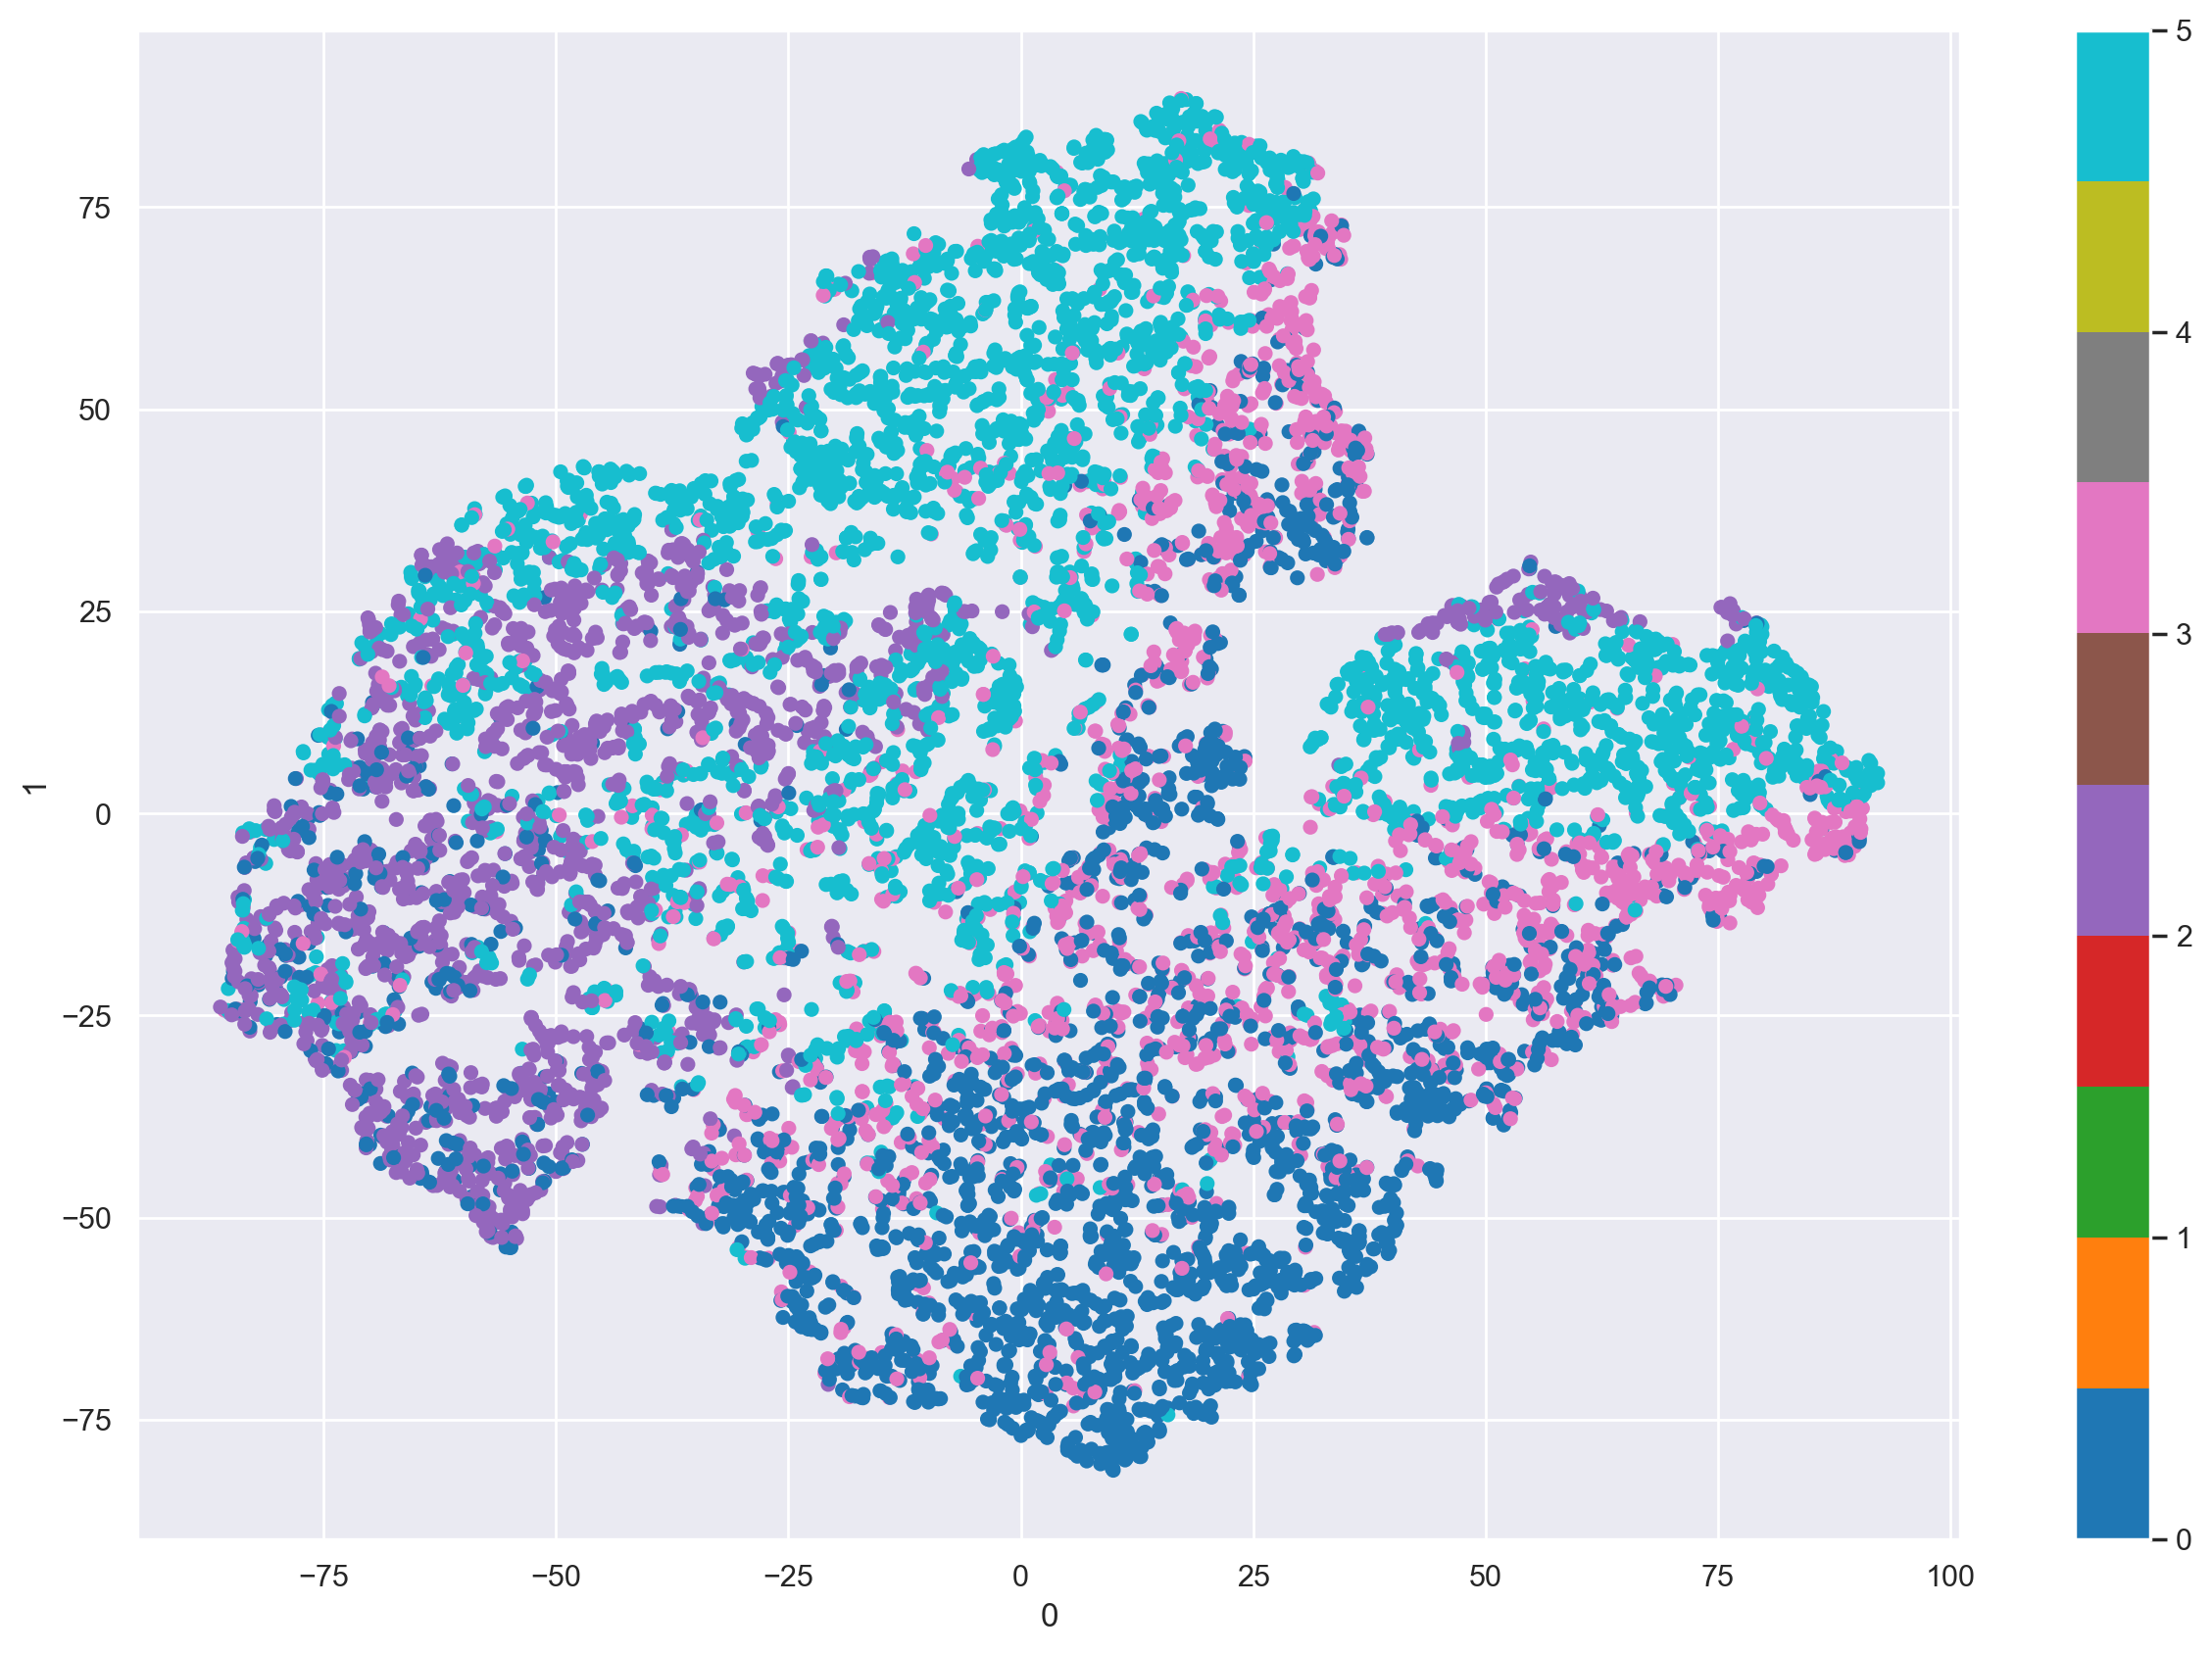

In [509]:
# t-SNE visualization
pd.DataFrame(two_dim).plot.scatter(x=0, y=1, c=df_['merged_labels'], colormap='tab10',figsize=(15,10))
plt.show()

# Clustering by Product

## Life Insurance

In [541]:
# Split variables into perspectives (example, requires critical thinking and domain knowledge)
prem_life = [
    'PremLife',
    'Children',
    'GeoLivArea',
    'Year_Sal',
]


df_prem_life = df[prem_life].copy()

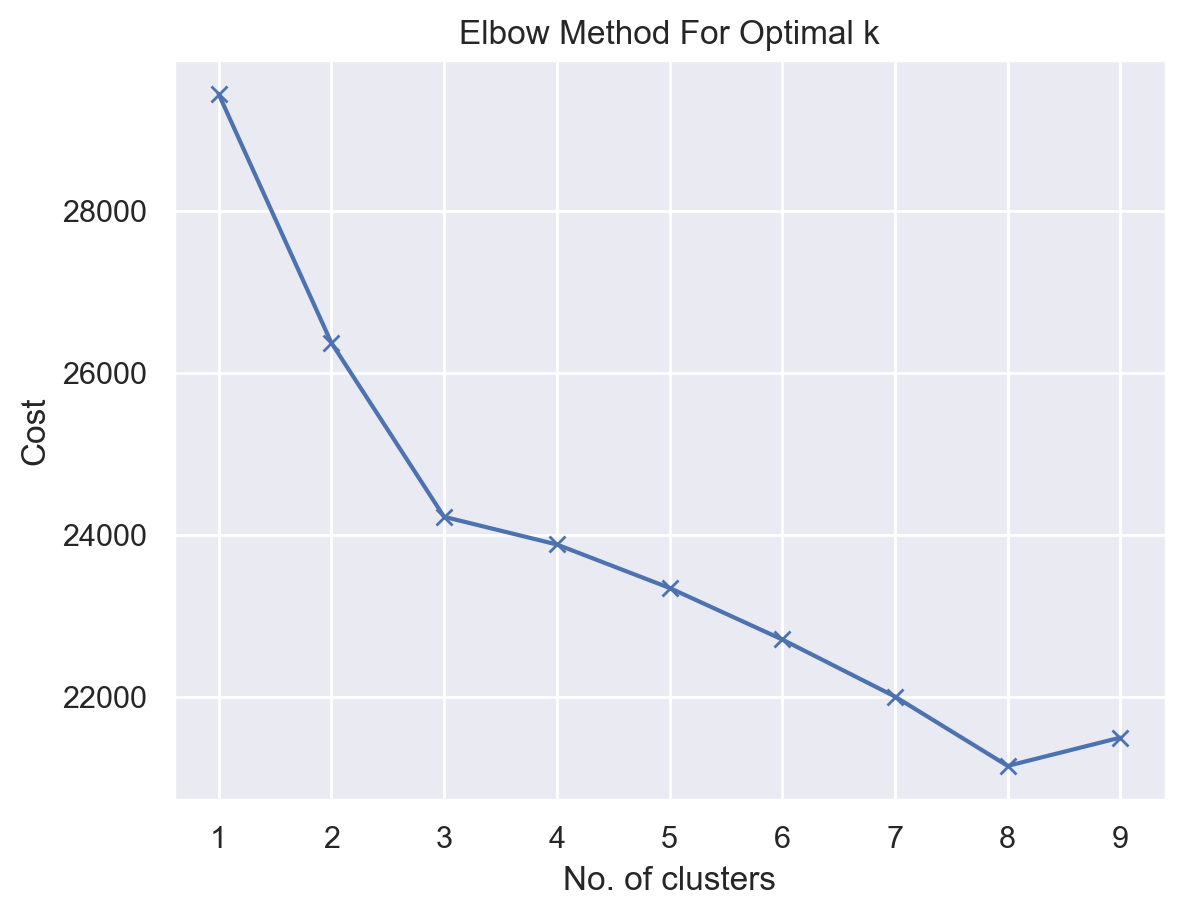

In [542]:
# Elbow curve to find optimal K
cost = []
K = range(1,10)
for num_clusters in list(K):
    kmode = KModes(n_clusters=num_clusters, init = "random", n_init = 5)
    kmode.fit_predict(df_prem_life)
    cost.append(kmode.cost_)
    
plt.plot(K, cost, 'bx-')
plt.xlabel('No. of clusters')
plt.ylabel('Cost')
plt.title('Elbow Method For Optimal k')
plt.show()

### Exploring 4 Clusters

In [543]:
categorical = [0,1]
kmode4 = KModes(n_clusters=4, init = "random", n_init = 5)
clusters_4 = kmode4.fit_predict(df_prem_life, categorical=categorical)

pd.Series(clusters_4).value_counts()

2    3605
0    3169
3    2194
1    1270
dtype: int64

In [544]:
df_prem_work_4_clusters=pd.DataFrame(clusters_4+1,index=df_prem_life.index).rename(columns={0:'prem_life_clusters_4'})

df_prem_work_4_clusters= pd.concat((df_prem_work_4_clusters, df_prem_life), axis=1)

df_prem_work_4_clusters_mean = df_prem_work_4_clusters.groupby('prem_life_clusters_4').mean()

In [545]:
def highlight_max(s):
    is_max = s == s.max()
    return ['background: red' if cell else '' for cell in is_max]
  
df_prem_work_4_clusters_mean.style.apply(highlight_max)

## Work Insurance

In [ ]:
df.columns

Index(['FirstPolYear', 'EducDeg', 'MonthSal', 'GeoLivArea', 'Children',
       'CustMonVal', 'ClaimsRate', 'PremMotor', 'PremHousehold', 'PremHealth',
       'PremLife', 'PremWork', 'Cust_Retention', 'Prem_Total', 'Year_Sal',
       'Commitment', 'Motor_Commitment', 'Houehold_Commitment',
       'Healthr_Commitment', 'Life_Commitment', 'Work_Commitment',
       'Yearly_Cost'],
      dtype='object')

In [563]:
# Split variables into perspectives (example, requires critical thinking and domain knowledge)
prem_work = [
    'PremWork',
    'GeoLivArea',
    'Year_Sal',
]


df_prem_work = df[prem_work].copy()

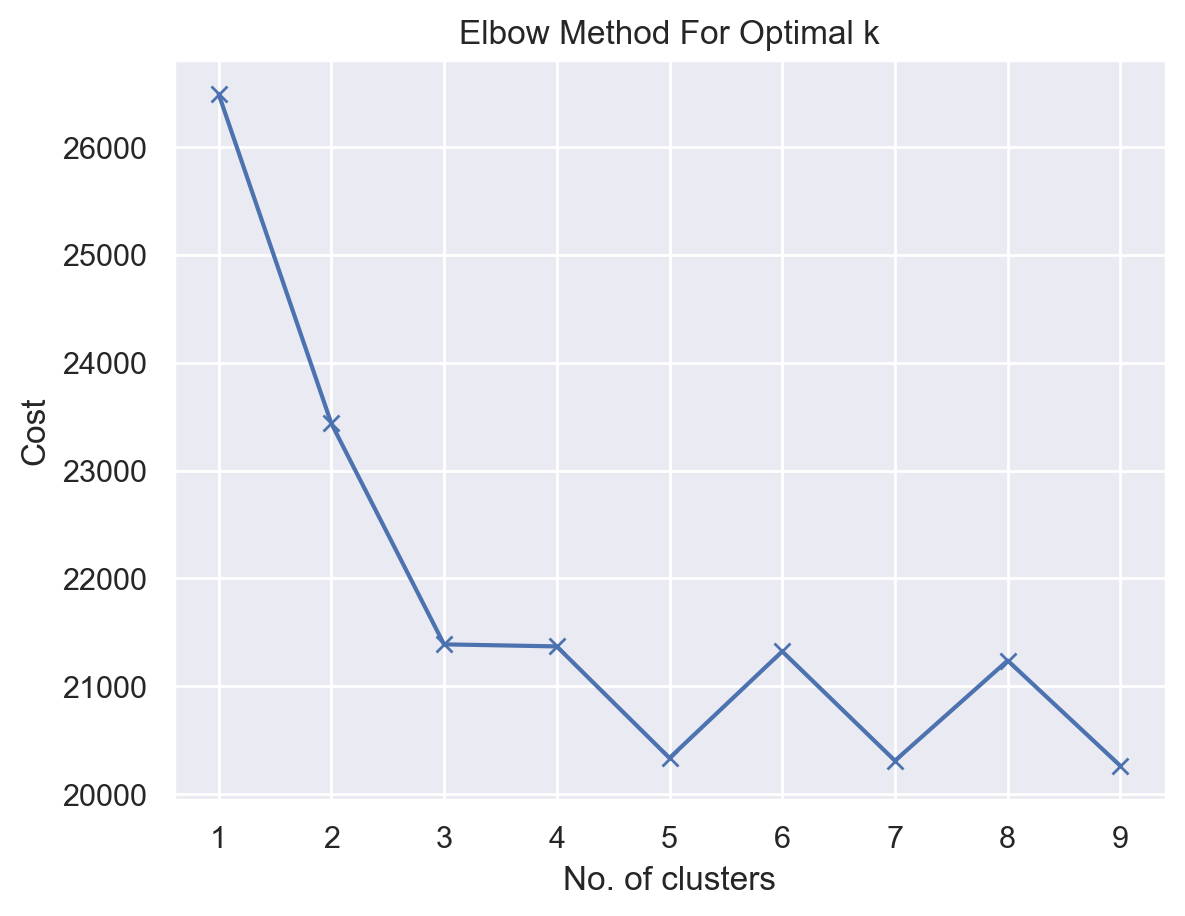

In [564]:
# Elbow curve to find optimal K
cost = []
K = range(1,8)
for num_clusters in list(K):
    kmode = KModes(n_clusters=num_clusters, init = "random", n_init = 5)
    kmode.fit_predict(df_prem_work)
    cost.append(kmode.cost_)
    
plt.plot(K, cost, 'bx-')
plt.xlabel('No. of clusters')
plt.ylabel('Cost')
plt.title('Elbow Method For Optimal k')
plt.show()

### Exploring 4 Clusters

In [565]:
categorical = [0,1]
kmode4 = KModes(n_clusters=3, init = "random", n_init = 5)
clusters_4 = kmode4.fit_predict(df_prem_life, categorical=categorical)

pd.Series(clusters_4).value_counts()

0    4200
2    3424
1    2614
dtype: int64

In [566]:
df_prem_work_4_clusters=pd.DataFrame(clusters_4+1,index=df_prem_work.index).rename(columns={0:'prem_work_clusters_4'})

df_prem_work_4_clusters= pd.concat((df_prem_work_4_clusters, df_prem_work), axis=1)

df_prem_work_4_clusters_mean = df_prem_work_4_clusters.groupby('prem_work_clusters_4').mean()

In [567]:
def highlight_max(s):
    is_max = s == s.max()
    return ['background: red' if cell else '' for cell in is_max]
  
df_prem_work_4_clusters_mean.style.apply(highlight_max)